<a href="https://colab.research.google.com/github/lofel888/ML_code_projects/blob/main/NLP_DZ_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание 1 (скачать и нормализовать данные)

In [ ]:
import kagglehub
import pandas as pd
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, f1_score, log_loss
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Скачивание данных
path = kagglehub.dataset_download("pratyushpuri/financial-news-market-events-dataset-2025")
print("Path to dataset files:", path)

print("\nСодержимое директории:")
for file in Path(path).iterdir():
    print(f"  - {file.name} ({'directory' if file.is_dir() else 'file'})")

Using Colab cache for faster access to the 'financial-news-market-events-dataset-2025' dataset.
Path to dataset files: /kaggle/input/financial-news-market-events-dataset-2025

Содержимое директории:
  - financial_news_events.csv (file)
  - financial_news_events.json (file)
  - financial_news_events.xlsx (file)


In [ ]:
csv_files = list(Path(path).glob("*.csv"))
print(f"\nНайдено CSV файлов: {len(csv_files)}")

datasets = {}
for csv_file in csv_files:
    try:
        df_name = csv_file.stem
        datasets[df_name] = pd.read_csv(csv_file)
        print(f"Загружен: {csv_file.name} - {len(datasets[df_name])} строк, {len(datasets[df_name].columns)} колонок")
    except Exception as e:
        print(f"Ошибка загрузки {csv_file.name}: {e}")

if len(csv_files) == 1:
    df = datasets[list(datasets.keys())[0]]
else:
    main_dataset = max(datasets.items(), key=lambda x: len(x[1]))
    df = main_dataset[1]
    print(f"\nОсновной датасет: {main_dataset[0]}")

print(f"\nРазмер данных: {df.shape}")


Найдено CSV файлов: 1
Загружен: financial_news_events.csv - 3024 строк, 12 колонок

Размер данных: (3024, 12)


In [ ]:
print("\n1. Информация о датафрейме:")
print(df.info())

print("\n2. Названия колонок:")
for i, col in enumerate(df.columns):
    print(f"   {i+1}. {col}")

print("\n3. Типы данных:")
print(df.dtypes.value_counts())


1. Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  3024 non-null   object 
 1   Headline              2876 non-null   object 
 2   Source                3024 non-null   object 
 3   Market_Event          3024 non-null   object 
 4   Market_Index          3024 non-null   object 
 5   Index_Change_Percent  2863 non-null   float64
 6   Trading_Volume        3024 non-null   float64
 7   Sentiment             2853 non-null   object 
 8   Sector                3024 non-null   object 
 9   Impact_Level          3024 non-null   object 
 10  Related_Company       3024 non-null   object 
 11  News_Url              2871 non-null   object 
dtypes: float64(2), object(10)
memory usage: 283.6+ KB
None

2. Названия колонок:
   1. Date
   2. Headline
   3. Source
   4. Market_Event
   5. Mark

In [ ]:
# Преобразование в тип данных datetime
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Удаляем строки с любыми NULL значениями
df = df.dropna()

print(f"Размер после удаления NULL: {df.shape}")
print(f"Осталось строк: {df.shape[0]}")

Размер после удаления NULL: (2443, 12)
Осталось строк: 2443


In [ ]:
import re
# Извлечение домена
def extract_domain_regex(url):
    pattern = r'https?://(?:www\.)?([^/]+)'
    match = re.search(pattern, url)
    if match:
        return match.group(1)
    return url

df['News_Url'] = df['News_Url'].apply(extract_domain_regex)
df['News_Url'].head()

/tmp/ipython-input-1831114470.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['News_Url'] = df['News_Url'].apply(extract_domain_regex)


,News_Url
2,moneycontrol.com
3,cnbc.com
4,bloomberg.com
5,reuters.com
6,cnbc.com


In [ ]:
# Удаляем все числа из столбца Market_Index
df['Market_Index'] = df['Market_Index'].apply(lambda x: re.sub(r'\d+', '', str(x)).strip())
df['Market_Index'].head()

/tmp/ipython-input-587814775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Market_Index'] = df['Market_Index'].apply(lambda x: re.sub(r'\d+', '', str(x)).strip())


,Market_Index
2,Shanghai Composite
3,NSE Nifty
4,Nasdaq Composite
5,IBOVESPA
6,Shanghai Composite


Нормализация и лемматизация текста

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

class TextNormalizer:
    def __init__(self):
        try:
            self.stop_words = set(stopwords.words('english'))
            self.lemmatizer = WordNetLemmatizer()
            # Финансовые стоп-слова
            self.financial_stop_words = {
                'said', 'inc', 'corp', 'ltd', 'co', 'stock', 'stocks', 'market',
                'company', 'companies', 'year', 'quarter', 'week', 'day', 'time',
                'percent', 'price', 'share', 'shares', 'trading', 'exchange'
            }
            self.stop_words.update(self.financial_stop_words)
            print(f" Загружено стоп-слов: {len(self.stop_words)}")
        except LookupError:
            print(" Ресурсы NLTK не найдены, используем базовые стоп-слова")
            # Базовый набор стоп-слов если NLTK не работает
            self.stop_words = {
                'a', 'an', 'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to',
                'for', 'of', 'with', 'by', 'is', 'am', 'are', 'was', 'were', 'be',
                'been', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would',
                'could', 'should', 'may', 'might', 'must', 'can'
            }
            self.lemmatizer = None

    def normalize_text(self, text, lemmatize=True, exclude_words=None):
        if pd.isna(text):
            return ""

        # Приведение к нижнему регистру
        text = str(text).lower()

        # Удаление пунктуации и специальных символов (сохраняем числа и финансовые символы)
        text = re.sub(r'[^\w\s\.\%\$\-\+]', ' ', text)

        # Удаление лишних пробелов
        text = re.sub(r'\s+', ' ', text).strip()

        # Токенизация
        words = text.split()

        # Удаление стоп-слов, слов из Impact_Level и лемматизация
        normalized_words = []
        for word in words:
            if (word not in self.stop_words and
                len(word) > 2 and
                (exclude_words is None or word not in exclude_words)):

                if lemmatize and self.lemmatizer is not None:
                    try:
                        # Лемматизация для глаголов и существительных
                        lemma = self.lemmatizer.lemmatize(word, pos='v')
                        lemma = self.lemmatizer.lemmatize(lemma, pos='n')
                        normalized_words.append(lemma)
                    except:
                        normalized_words.append(word)
                else:
                    normalized_words.append(word)

        return ' '.join(normalized_words)

normalizer = TextNormalizer()


text_columns = [col for col in df.columns if df[col].dtype == 'object']

Impact_Level_words = set()
if 'Impact_Level' in df.columns:

    for Impact_Level_text in df['Impact_Level'].dropna():
        if pd.notna(Impact_Level_text):
            words = str(Impact_Level_text).lower().split()
            Impact_Level_words.update(words)

    print(f"Собрано слов для исключения из Impact_Level: {len(Impact_Level_words)}")

# Нормализуем текст с исключением слов из Impact_Level
df_processed = df.copy()
for col in text_columns:
    print(f"Нормализация колонки: {col}")
    df_processed[f'{col}_normalized'] = df_processed[col].apply(
        lambda x: normalizer.normalize_text(x, lemmatize=True, exclude_words=Impact_Level_words)
    )

# Объединяем все текстовые колонки в all_text
if len(text_columns) > 1:
    df_processed['all_text'] = df_processed[[f'{col}_normalized' for col in text_columns]].apply(
        lambda x: ' '.join(x.dropna().astype(str)), axis=1
    )
    print("Все текстовые колонки объединены в 'all_text'")
else:
    df_processed['all_text'] = df_processed[f'{text_columns[0]}_normalized']
    print(f"Используется колонка '{text_columns[0]}_normalized' как 'all_text'")


 Загружено стоп-слов: 219
Собрано слов для исключения из Impact_Level: 3
Нормализация колонки: Headline


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Нормализация колонки: Source
Нормализация колонки: Market_Event
Нормализация колонки: Market_Index
Нормализация колонки: Sentiment
Нормализация колонки: Sector
Нормализация колонки: Impact_Level
Нормализация колонки: Related_Company
Нормализация колонки: News_Url
Все текстовые колонки объединены в 'all_text'


In [ ]:
# Убираем все числовые значения из столбца all_text
df_processed['all_text'] = df_processed['all_text'].str.replace(r'\d+\s*', '', regex=True)
df_processed['all_text'].head()

,all_text
2,new house data release show slowdown activity ...
3,massive buyback program announce consumer good...
4,government spend bill expect stimulate economy...
5,central bank maintain status quo interest rat ...
6,tech giant new product launch spark sector-wid...


Задание 2 (разбить датасет на трейн и тест)

Многоклассовая классфикация

In [ ]:
    # X - признаки (текст)
X = df_processed['all_text']

    # y - целевая переменная (Impact_Level)
y = df_processed['Impact_Level']

print(f"Размер X (all_text): {X.shape}")
print(f"Размер y (Impact_Level): {y.shape}")

print(f"\nРаспределение целевой переменной:")
print(y.value_counts())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42,stratify=y)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

    # Анализ распределения классов
print(f"\n Распределение классов:")
print("Train set:")
print(y_train.value_counts(normalize=True))
print("\nTest set:")
print(y_test.value_counts(normalize=True))

Размер X (all_text): (2443,)
Размер y (Impact_Level): (2443,)

Распределение целевой переменной:
Impact_Level
Low       829
Medium    813
High      801
Name: count, dtype: int64
X_train: (1465,)
X_test: (978,)
y_train: (1465,)
y_test: (978,)

 Распределение классов:
Train set:
Impact_Level
Low       0.339249
Medium    0.333106
High      0.327645
Name: proportion, dtype: float64

Test set:
Impact_Level
Low       0.339468
Medium    0.332311
High      0.328221
Name: proportion, dtype: float64


Задание 3

Многоклассовая классификация

Epoch 1: Train Loss = 1.0947, Test Loss = 1.0985
Epoch 2: Train Loss = 1.0906, Test Loss = 1.0985
Epoch 3: Train Loss = 1.0864, Test Loss = 1.0986
Epoch 4: Train Loss = 1.0821, Test Loss = 1.0987
Epoch 5: Train Loss = 1.0779, Test Loss = 1.0989
Epoch 6: Train Loss = 1.0738, Test Loss = 1.0991


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 7: Train Loss = 1.0697, Test Loss = 1.0994
Epoch 8: Train Loss = 1.0657, Test Loss = 1.0997
Epoch 9: Train Loss = 1.0619, Test Loss = 1.1001
Epoch 10: Train Loss = 1.0581, Test Loss = 1.1005
Epoch 11: Train Loss = 1.0544, Test Loss = 1.1009
Epoch 12: Train Loss = 1.0509, Test Loss = 1.1014
Epoch 13: Train Loss = 1.0475, Test Loss = 1.1019
Epoch 14: Train Loss = 1.0441, Test Loss = 1.1025
Epoch 15: Train Loss = 1.0409, Test Loss = 1.1031
Epoch 16: Train Loss = 1.0377, Test Loss = 1.1037
Epoch 17: Train Loss = 1.0347, Test Loss = 1.1043
Epoch 18: Train Loss = 1.0317, Test Loss = 1.1049
Epoch 19: Train Loss = 1.0288, Test Loss = 1.1055
Epoch 20: Train Loss = 1.0260, Test Loss = 1.1062
Epoch 21: Train Loss = 1.0233, Test Loss = 1.1069


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 22: Train Loss = 1.0207, Test Loss = 1.1075
Epoch 23: Train Loss = 1.0181, Test Loss = 1.1082
Epoch 24: Train Loss = 1.0156, Test Loss = 1.1089
Epoch 25: Train Loss = 1.0131, Test Loss = 1.1096
Epoch 26: Train Loss = 1.0107, Test Loss = 1.1103
Epoch 27: Train Loss = 1.0084, Test Loss = 1.1110
Epoch 28: Train Loss = 1.0061, Test Loss = 1.1117
Epoch 29: Train Loss = 1.0039, Test Loss = 1.1125
Epoch 30: Train Loss = 1.0017, Test Loss = 1.1132
Epoch 31: Train Loss = 0.9995, Test Loss = 1.1139
Epoch 32: Train Loss = 0.9975, Test Loss = 1.1146
Epoch 33: Train Loss = 0.9954, Test Loss = 1.1153
Epoch 34: Train Loss = 0.9934, Test Loss = 1.1160
Epoch 35: Train Loss = 0.9914, Test Loss = 1.1167


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 36: Train Loss = 0.9895, Test Loss = 1.1175
Epoch 37: Train Loss = 0.9876, Test Loss = 1.1182
Epoch 38: Train Loss = 0.9858, Test Loss = 1.1189
Epoch 39: Train Loss = 0.9839, Test Loss = 1.1196
Epoch 40: Train Loss = 0.9821, Test Loss = 1.1203
Epoch 41: Train Loss = 0.9804, Test Loss = 1.1210
Epoch 42: Train Loss = 0.9786, Test Loss = 1.1217
Epoch 43: Train Loss = 0.9769, Test Loss = 1.1224
Epoch 44: Train Loss = 0.9753, Test Loss = 1.1231
Epoch 45: Train Loss = 0.9736, Test Loss = 1.1237
Epoch 46: Train Loss = 0.9720, Test Loss = 1.1244
Epoch 47: Train Loss = 0.9704, Test Loss = 1.1251
Epoch 48: Train Loss = 0.9688, Test Loss = 1.1258
Epoch 49: Train Loss = 0.9673, Test Loss = 1.1264
Epoch 50: Train Loss = 0.9658, Test Loss = 1.1271


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 51: Train Loss = 0.9642, Test Loss = 1.1278
Epoch 52: Train Loss = 0.9628, Test Loss = 1.1284
Epoch 53: Train Loss = 0.9613, Test Loss = 1.1291
Epoch 54: Train Loss = 0.9599, Test Loss = 1.1297
Epoch 55: Train Loss = 0.9584, Test Loss = 1.1303
Epoch 56: Train Loss = 0.9570, Test Loss = 1.1310
Epoch 57: Train Loss = 0.9556, Test Loss = 1.1316
Epoch 58: Train Loss = 0.9543, Test Loss = 1.1322
Epoch 59: Train Loss = 0.9529, Test Loss = 1.1328
Epoch 60: Train Loss = 0.9516, Test Loss = 1.1335
Epoch 61: Train Loss = 0.9503, Test Loss = 1.1341
Epoch 62: Train Loss = 0.9490, Test Loss = 1.1347
Epoch 63: Train Loss = 0.9477, Test Loss = 1.1353


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 64: Train Loss = 0.9464, Test Loss = 1.1359
Epoch 65: Train Loss = 0.9451, Test Loss = 1.1364
Epoch 66: Train Loss = 0.9439, Test Loss = 1.1370
Epoch 67: Train Loss = 0.9427, Test Loss = 1.1376
Epoch 68: Train Loss = 0.9414, Test Loss = 1.1382
Epoch 69: Train Loss = 0.9402, Test Loss = 1.1387
Epoch 70: Train Loss = 0.9391, Test Loss = 1.1393
Epoch 71: Train Loss = 0.9379, Test Loss = 1.1399
Epoch 72: Train Loss = 0.9367, Test Loss = 1.1404
Epoch 73: Train Loss = 0.9356, Test Loss = 1.1410
Epoch 74: Train Loss = 0.9344, Test Loss = 1.1415
Epoch 75: Train Loss = 0.9333, Test Loss = 1.1420
Epoch 76: Train Loss = 0.9322, Test Loss = 1.1426
Epoch 77: Train Loss = 0.9310, Test Loss = 1.1431
Epoch 78: Train Loss = 0.9299, Test Loss = 1.1436


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 79: Train Loss = 0.9289, Test Loss = 1.1441
Epoch 80: Train Loss = 0.9278, Test Loss = 1.1446
Epoch 81: Train Loss = 0.9267, Test Loss = 1.1452
Epoch 82: Train Loss = 0.9256, Test Loss = 1.1457
Epoch 83: Train Loss = 0.9246, Test Loss = 1.1462
Epoch 84: Train Loss = 0.9236, Test Loss = 1.1467
Epoch 85: Train Loss = 0.9225, Test Loss = 1.1471
Epoch 86: Train Loss = 0.9215, Test Loss = 1.1476
Epoch 87: Train Loss = 0.9205, Test Loss = 1.1481
Epoch 88: Train Loss = 0.9195, Test Loss = 1.1486
Epoch 89: Train Loss = 0.9185, Test Loss = 1.1491
Epoch 90: Train Loss = 0.9175, Test Loss = 1.1495
Epoch 91: Train Loss = 0.9165, Test Loss = 1.1500
Epoch 92: Train Loss = 0.9155, Test Loss = 1.1505
Epoch 93: Train Loss = 0.9146, Test Loss = 1.1509


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 94: Train Loss = 0.9136, Test Loss = 1.1514
Epoch 95: Train Loss = 0.9127, Test Loss = 1.1518
Epoch 96: Train Loss = 0.9117, Test Loss = 1.1523
Epoch 97: Train Loss = 0.9108, Test Loss = 1.1527
Epoch 98: Train Loss = 0.9099, Test Loss = 1.1531
Epoch 99: Train Loss = 0.9089, Test Loss = 1.1536
Epoch 100: Train Loss = 0.9080, Test Loss = 1.1540


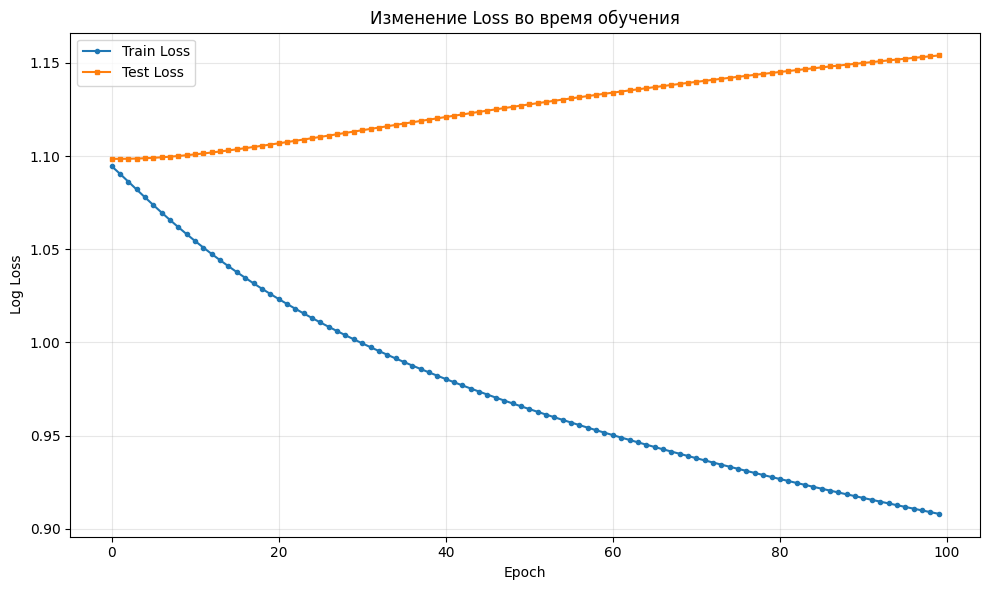

Micro Accuracy: 0.3446
Macro Accuracy: 0.5631
Micro F1: 0.3446
Macro F1: 0.3438

Итоговый Train Loss: 0.9080
Итоговый Test Loss: 1.1540


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,min_df=2,max_df=0.85,ngram_range=(1, 2),stop_words='english',lowercase=True,strip_accents='unicode',analyzer='word')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


sgd_lr = SGDClassifier(loss='log_loss',penalty='l2',alpha=0.0001,max_iter=1,learning_rate='constant',eta0=0.01,random_state=42,warm_start=True,verbose=0)

train_losses = []
test_losses = []


for epoch in range(100):

    sgd_lr.fit(X_train_tfidf, y_train)

    y_pred_proba_train = sgd_lr.predict_proba(X_train_tfidf)
    y_pred_proba_test = sgd_lr.predict_proba(X_test_tfidf)

    train_loss = log_loss(y_train, y_pred_proba_train)
    test_loss = log_loss(y_test, y_pred_proba_test)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

    if epoch > 0 and abs(train_losses[-1] - train_losses[-2]) < 1e-4:
        print(f"Сходимость достигнута на эпохе {epoch+1}")
        break


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o', markersize=3)
plt.plot(test_losses, label='Test Loss', marker='s', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Изменение Loss во время обучения')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


y_pred_train = sgd_lr.predict(X_train_tfidf)
y_pred_test = sgd_lr.predict(X_test_tfidf)

# Micro Accuracy
test_micro_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Micro Accuracy: {test_micro_accuracy:.4f}')

# Macro Accuracy
def macro_accuracy_score(y_true, y_pred):
    classes = np.unique(np.concatenate([y_true, y_pred]))
    class_accuracies = []

    for class_label in classes:
        y_true_binary = (y_true == class_label)
        y_pred_binary = (y_pred == class_label)
        class_accuracy = accuracy_score(y_true_binary, y_pred_binary)
        class_accuracies.append(class_accuracy)

    return np.mean(class_accuracies)

macro_accuracy_test = macro_accuracy_score(y_test, y_pred_test)
print(f"Macro Accuracy: {macro_accuracy_test:.4f}")

# Micro и Macro F1
test_micro_f1 = f1_score(y_test, y_pred_test, average='micro')
test_macro_f1 = f1_score(y_test, y_pred_test, average='macro')
print(f'Micro F1: {test_micro_f1:.4f}')
print(f'Macro F1: {test_macro_f1:.4f}')

print(f"\nИтоговый Train Loss: {train_losses[-1]:.4f}")
print(f"Итоговый Test Loss: {test_losses[-1]:.4f}")

In [ ]:
# Анализ самых важных слов по весам модели для каждого класса
def analyze_important_words_by_class(model, vectorizer, class_names, top_n=10):

    feature_names = vectorizer.get_feature_names_out()

    print("Cамые важные n-граммы по весам модели")

    for class_idx, class_name in enumerate(class_names):
        print(f"\nКласс '{class_name}'")

        weights = model.coef_[class_idx]

        # Сортируем слова по важности
        feature_importance = list(zip(feature_names, weights))
        sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

        top_features = sorted_features[:top_n]

        print(f"{top_n} самых важных n-грамм:")
        for i, (word, weight) in enumerate(top_features, 1):
            sign = "+" if weight > 0 else "-"
            print(f"  {i:2d}. {sign} {word:20} : {weight:7.4f}")

analyze_important_words_by_class(sgd_lr, tfidf_vectorizer, sgd_lr.classes_, top_n=10)

Cамые важные n-граммы по весам модели

Класс 'High'
10 самых важных n-грамм:
   1. - tesla                : -1.4912
   2. - barron               : -1.1828
   3. - agriculture          : -1.0279
   4. + material             :  1.0202
   5. + material goldman     :  0.9354
   6. - neutral energy       : -0.8624
   7. - energy               : -0.8462
   8. - microsoft            : -0.8440
   9. + chain disruption     :  0.8347
  10. + disruption           :  0.8347

Класс 'Low'
10 самых важных n-грамм:
   1. - cnbc                 : -1.2969
   2. - rate change          : -1.2643
   3. - economic             : -1.1647
   4. - fluctuation          : -0.9885
   5. - cnbc com             : -0.9588
   6. - bond fluctuation     : -0.9537
   7. - material             : -0.9306
   8. - bond                 : -0.8995
   9. - industry moneycontrol : -0.8521
  10. - change               : -0.8265

Класс 'Medium'
10 самых важных n-грамм:
   1. - technology           : -1.1252
   2. - bloomberg com   

Задание 4

Обучение с L1 регуляризацией, вес = 0.0001
Epoch 1: Train Loss = 1.0951, Test Loss = 1.0985
Epoch 2: Train Loss = 1.0914, Test Loss = 1.0985


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 3: Train Loss = 1.0877, Test Loss = 1.0985
Epoch 4: Train Loss = 1.0841, Test Loss = 1.0985
Epoch 5: Train Loss = 1.0805, Test Loss = 1.0986
Epoch 6: Train Loss = 1.0769, Test Loss = 1.0988
Epoch 7: Train Loss = 1.0735, Test Loss = 1.0990
Epoch 8: Train Loss = 1.0701, Test Loss = 1.0993
Epoch 9: Train Loss = 1.0669, Test Loss = 1.0996
Epoch 10: Train Loss = 1.0637, Test Loss = 1.0999


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 11: Train Loss = 1.0607, Test Loss = 1.1003
Epoch 12: Train Loss = 1.0578, Test Loss = 1.1007
Epoch 13: Train Loss = 1.0549, Test Loss = 1.1011
Epoch 14: Train Loss = 1.0522, Test Loss = 1.1015
Epoch 15: Train Loss = 1.0495, Test Loss = 1.1019
Epoch 16: Train Loss = 1.0469, Test Loss = 1.1024
Epoch 17: Train Loss = 1.0444, Test Loss = 1.1028
Epoch 18: Train Loss = 1.0420, Test Loss = 1.1033
Epoch 19: Train Loss = 1.0396, Test Loss = 1.1038


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 20: Train Loss = 1.0374, Test Loss = 1.1043
Epoch 21: Train Loss = 1.0351, Test Loss = 1.1048
Epoch 22: Train Loss = 1.0330, Test Loss = 1.1053
Epoch 23: Train Loss = 1.0309, Test Loss = 1.1058
Epoch 24: Train Loss = 1.0288, Test Loss = 1.1063
Epoch 25: Train Loss = 1.0268, Test Loss = 1.1068
Epoch 26: Train Loss = 1.0249, Test Loss = 1.1073
Epoch 27: Train Loss = 1.0230, Test Loss = 1.1078
Epoch 28: Train Loss = 1.0211, Test Loss = 1.1083


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 29: Train Loss = 1.0193, Test Loss = 1.1088
Epoch 30: Train Loss = 1.0175, Test Loss = 1.1094
Epoch 31: Train Loss = 1.0158, Test Loss = 1.1099
Epoch 32: Train Loss = 1.0141, Test Loss = 1.1104
Epoch 33: Train Loss = 1.0124, Test Loss = 1.1109
Epoch 34: Train Loss = 1.0107, Test Loss = 1.1115
Epoch 35: Train Loss = 1.0091, Test Loss = 1.1120
Epoch 36: Train Loss = 1.0076, Test Loss = 1.1125


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 37: Train Loss = 1.0060, Test Loss = 1.1130
Epoch 38: Train Loss = 1.0045, Test Loss = 1.1135
Epoch 39: Train Loss = 1.0030, Test Loss = 1.1141
Epoch 40: Train Loss = 1.0015, Test Loss = 1.1146
Epoch 41: Train Loss = 1.0001, Test Loss = 1.1151
Epoch 42: Train Loss = 0.9987, Test Loss = 1.1156
Epoch 43: Train Loss = 0.9973, Test Loss = 1.1161
Epoch 44: Train Loss = 0.9959, Test Loss = 1.1166


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 45: Train Loss = 0.9946, Test Loss = 1.1171
Epoch 46: Train Loss = 0.9932, Test Loss = 1.1176
Epoch 47: Train Loss = 0.9919, Test Loss = 1.1181
Epoch 48: Train Loss = 0.9906, Test Loss = 1.1186
Epoch 49: Train Loss = 0.9894, Test Loss = 1.1191
Epoch 50: Train Loss = 0.9881, Test Loss = 1.1196
Epoch 51: Train Loss = 0.9869, Test Loss = 1.1201
Epoch 52: Train Loss = 0.9856, Test Loss = 1.1206


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 53: Train Loss = 0.9844, Test Loss = 1.1211
Epoch 54: Train Loss = 0.9833, Test Loss = 1.1216
Epoch 55: Train Loss = 0.9821, Test Loss = 1.1221
Epoch 56: Train Loss = 0.9809, Test Loss = 1.1226
Epoch 57: Train Loss = 0.9798, Test Loss = 1.1231
Epoch 58: Train Loss = 0.9787, Test Loss = 1.1235
Epoch 59: Train Loss = 0.9776, Test Loss = 1.1240
Epoch 60: Train Loss = 0.9765, Test Loss = 1.1245
Epoch 61: Train Loss = 0.9754, Test Loss = 1.1249


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 62: Train Loss = 0.9743, Test Loss = 1.1254
Epoch 63: Train Loss = 0.9732, Test Loss = 1.1258
Epoch 64: Train Loss = 0.9722, Test Loss = 1.1263
Epoch 65: Train Loss = 0.9711, Test Loss = 1.1267
Epoch 66: Train Loss = 0.9701, Test Loss = 1.1272
Epoch 67: Train Loss = 0.9691, Test Loss = 1.1276
Epoch 68: Train Loss = 0.9681, Test Loss = 1.1280
Epoch 69: Train Loss = 0.9671, Test Loss = 1.1285
Epoch 70: Train Loss = 0.9661, Test Loss = 1.1289


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 71: Train Loss = 0.9652, Test Loss = 1.1293
Epoch 72: Train Loss = 0.9642, Test Loss = 1.1297
Epoch 73: Train Loss = 0.9632, Test Loss = 1.1301
Epoch 74: Train Loss = 0.9623, Test Loss = 1.1306
Epoch 75: Train Loss = 0.9614, Test Loss = 1.1310
Epoch 76: Train Loss = 0.9604, Test Loss = 1.1314
Epoch 77: Train Loss = 0.9595, Test Loss = 1.1318
Epoch 78: Train Loss = 0.9586, Test Loss = 1.1322
Epoch 79: Train Loss = 0.9577, Test Loss = 1.1326


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 80: Train Loss = 0.9568, Test Loss = 1.1329
Epoch 81: Train Loss = 0.9559, Test Loss = 1.1333
Epoch 82: Train Loss = 0.9550, Test Loss = 1.1337
Epoch 83: Train Loss = 0.9542, Test Loss = 1.1341
Epoch 84: Train Loss = 0.9533, Test Loss = 1.1345
Epoch 85: Train Loss = 0.9524, Test Loss = 1.1349
Epoch 86: Train Loss = 0.9516, Test Loss = 1.1352
Epoch 87: Train Loss = 0.9508, Test Loss = 1.1356
Epoch 88: Train Loss = 0.9499, Test Loss = 1.1360
Epoch 89: Train Loss = 0.9491, Test Loss = 1.1363


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 90: Train Loss = 0.9483, Test Loss = 1.1367
Epoch 91: Train Loss = 0.9475, Test Loss = 1.1370
Epoch 92: Train Loss = 0.9466, Test Loss = 1.1374
Epoch 93: Train Loss = 0.9458, Test Loss = 1.1377
Epoch 94: Train Loss = 0.9450, Test Loss = 1.1381
Epoch 95: Train Loss = 0.9442, Test Loss = 1.1384
Epoch 96: Train Loss = 0.9435, Test Loss = 1.1388
Epoch 97: Train Loss = 0.9427, Test Loss = 1.1391
Epoch 98: Train Loss = 0.9419, Test Loss = 1.1394
Epoch 99: Train Loss = 0.9411, Test Loss = 1.1398
Epoch 100: Train Loss = 0.9404, Test Loss = 1.1401


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


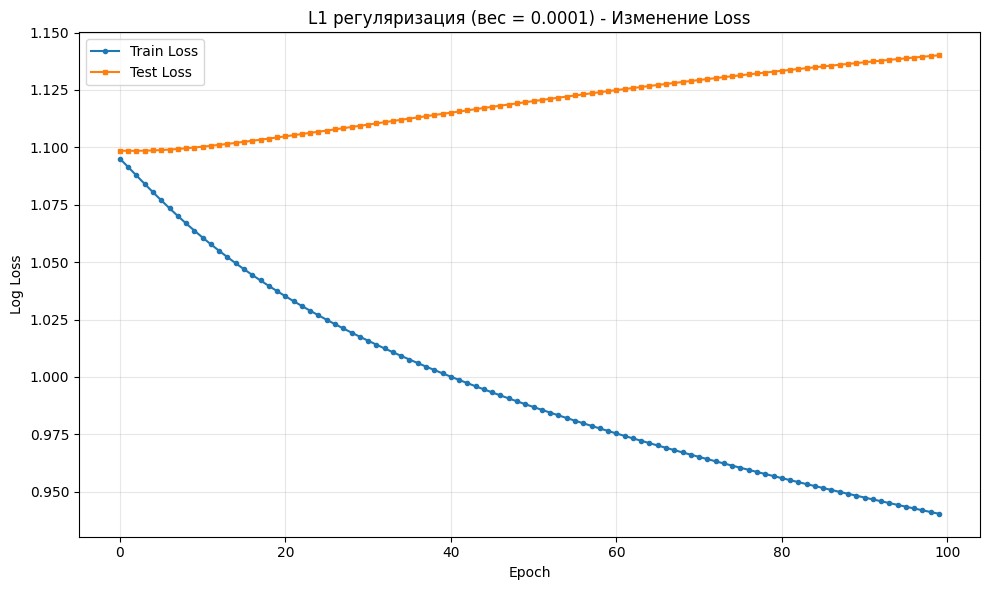


Результаты для вес = 0.0001:
Micro Accuracy: 0.3395
Macro Accuracy: 0.5596
Micro F1: 0.3395
Macro F1: 0.3385
Итоговый Train Loss: 0.9404
Итоговый Test Loss: 1.1401
Обучение с L1 регуляризацией, вес = 0.001
Epoch 1: Train Loss = 1.0972, Test Loss = 1.0986
Epoch 2: Train Loss = 1.0959, Test Loss = 1.0986
Epoch 3: Train Loss = 1.0947, Test Loss = 1.0986
Epoch 4: Train Loss = 1.0936, Test Loss = 1.0986
Epoch 5: Train Loss = 1.0926, Test Loss = 1.0986
Epoch 6: Train Loss = 1.0916, Test Loss = 1.0987
Epoch 7: Train Loss = 1.0908, Test Loss = 1.0987
Epoch 8: Train Loss = 1.0900, Test Loss = 1.0988


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 9: Train Loss = 1.0893, Test Loss = 1.0988
Epoch 10: Train Loss = 1.0887, Test Loss = 1.0989
Epoch 11: Train Loss = 1.0882, Test Loss = 1.0989
Epoch 12: Train Loss = 1.0877, Test Loss = 1.0990
Epoch 13: Train Loss = 1.0872, Test Loss = 1.0991
Epoch 14: Train Loss = 1.0868, Test Loss = 1.0991
Epoch 15: Train Loss = 1.0865, Test Loss = 1.0992
Epoch 16: Train Loss = 1.0862, Test Loss = 1.0992
Epoch 17: Train Loss = 1.0859, Test Loss = 1.0992
Epoch 18: Train Loss = 1.0857, Test Loss = 1.0992
Epoch 19: Train Loss = 1.0855, Test Loss = 1.0992
Epoch 20: Train Loss = 1.0853, Test Loss = 1.0992
Epoch 21: Train Loss = 1.0851, Test Loss = 1.0992
Epoch 22: Train Loss = 1.0850, Test Loss = 1.0992


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 23: Train Loss = 1.0849, Test Loss = 1.0992
Epoch 24: Train Loss = 1.0848, Test Loss = 1.0992
Epoch 25: Train Loss = 1.0847, Test Loss = 1.0993
Сходимость достигнута на эпохе 25


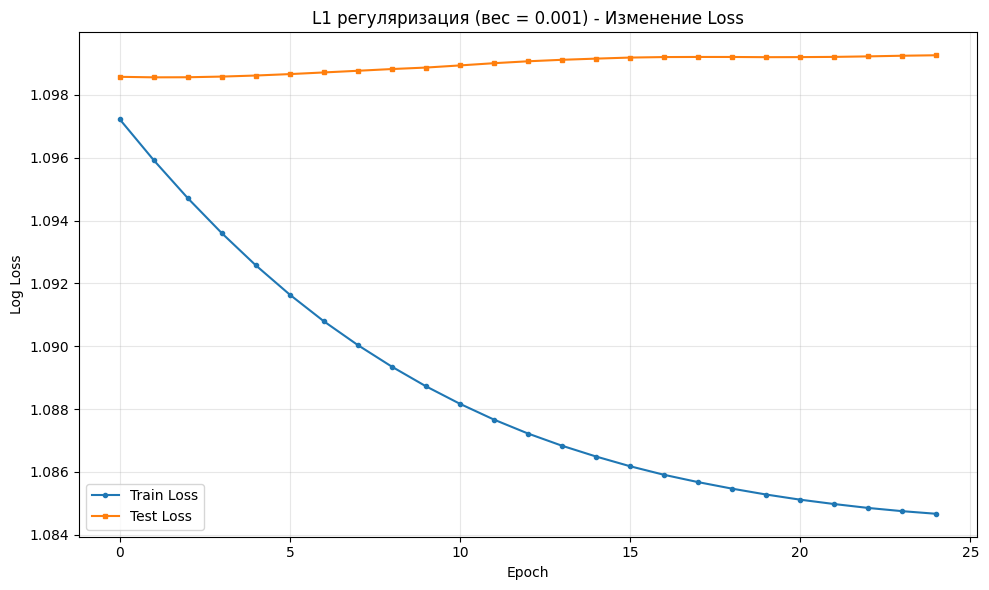


Результаты для вес = 0.001:
Micro Accuracy: 0.3231
Macro Accuracy: 0.5487
Micro F1: 0.3231
Macro F1: 0.3126
Итоговый Train Loss: 1.0847
Итоговый Test Loss: 1.0993
Обучение с L1 регуляризацией, вес = 0.002
Epoch 1: Train Loss = 1.0981, Test Loss = 1.0986
Epoch 2: Train Loss = 1.0976, Test Loss = 1.0986
Epoch 3: Train Loss = 1.0972, Test Loss = 1.0986
Epoch 4: Train Loss = 1.0969, Test Loss = 1.0986
Epoch 5: Train Loss = 1.0966, Test Loss = 1.0986
Epoch 6: Train Loss = 1.0963, Test Loss = 1.0986
Epoch 7: Train Loss = 1.0961, Test Loss = 1.0986
Epoch 8: Train Loss = 1.0959, Test Loss = 1.0986
Epoch 9: Train Loss = 1.0958, Test Loss = 1.0986


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 10: Train Loss = 1.0956, Test Loss = 1.0986
Epoch 11: Train Loss = 1.0955, Test Loss = 1.0986
Epoch 12: Train Loss = 1.0954, Test Loss = 1.0985
Сходимость достигнута на эпохе 12


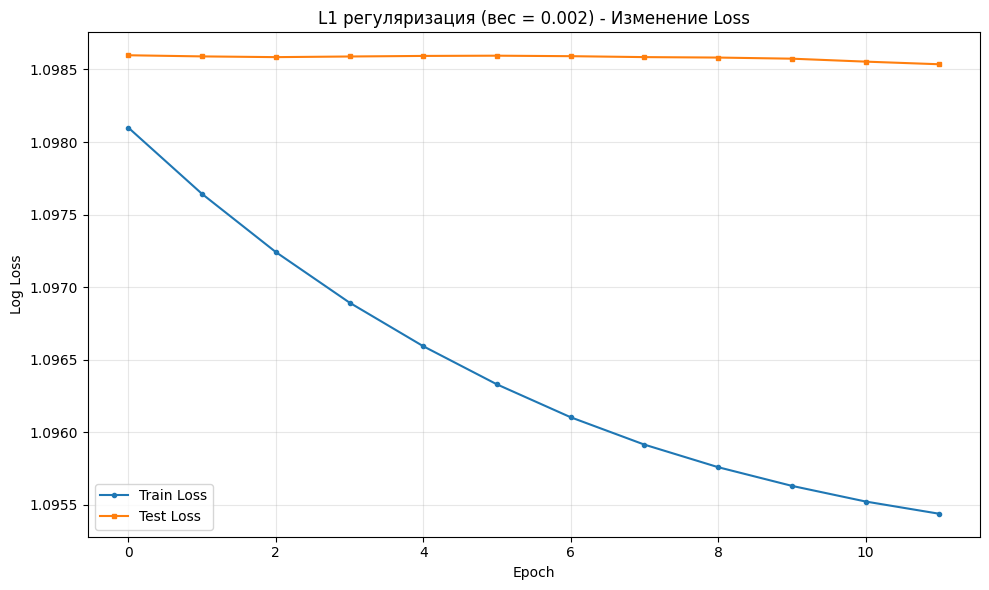


Результаты для вес = 0.002:
Micro Accuracy: 0.3374
Macro Accuracy: 0.5583
Micro F1: 0.3374
Macro F1: 0.3003
Итоговый Train Loss: 1.0954
Итоговый Test Loss: 1.0985
Обучение с L1 регуляризацией, вес = 0.0025
Epoch 1: Train Loss = 1.0983, Test Loss = 1.0986
Epoch 2: Train Loss = 1.0981, Test Loss = 1.0986
Epoch 3: Train Loss = 1.0979, Test Loss = 1.0986
Epoch 4: Train Loss = 1.0977, Test Loss = 1.0986
Epoch 5: Train Loss = 1.0976, Test Loss = 1.0986
Epoch 6: Train Loss = 1.0975, Test Loss = 1.0986
Epoch 7: Train Loss = 1.0974, Test Loss = 1.0986
Сходимость достигнута на эпохе 7


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

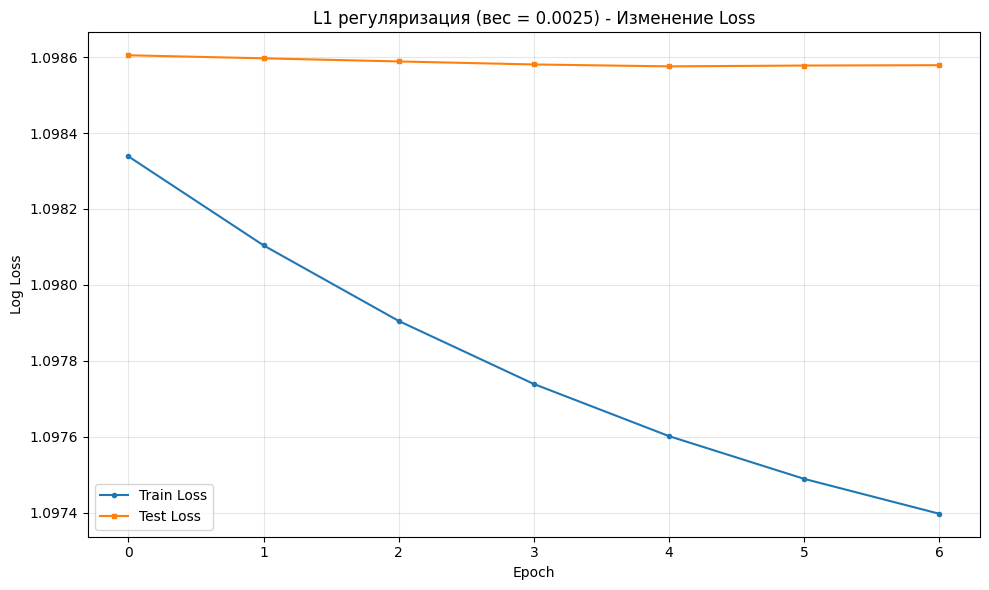


Результаты для вес = 0.0025:
Micro Accuracy: 0.3344
Macro Accuracy: 0.5562
Micro F1: 0.3344
Macro F1: 0.2748
Итоговый Train Loss: 1.0974
Итоговый Test Loss: 1.0986
Обучение с L1 регуляризацией, вес = 0.003
Epoch 1: Train Loss = 1.0985, Test Loss = 1.0986
Epoch 2: Train Loss = 1.0984, Test Loss = 1.0986
Epoch 3: Train Loss = 1.0983, Test Loss = 1.0986
Сходимость достигнута на эпохе 3


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


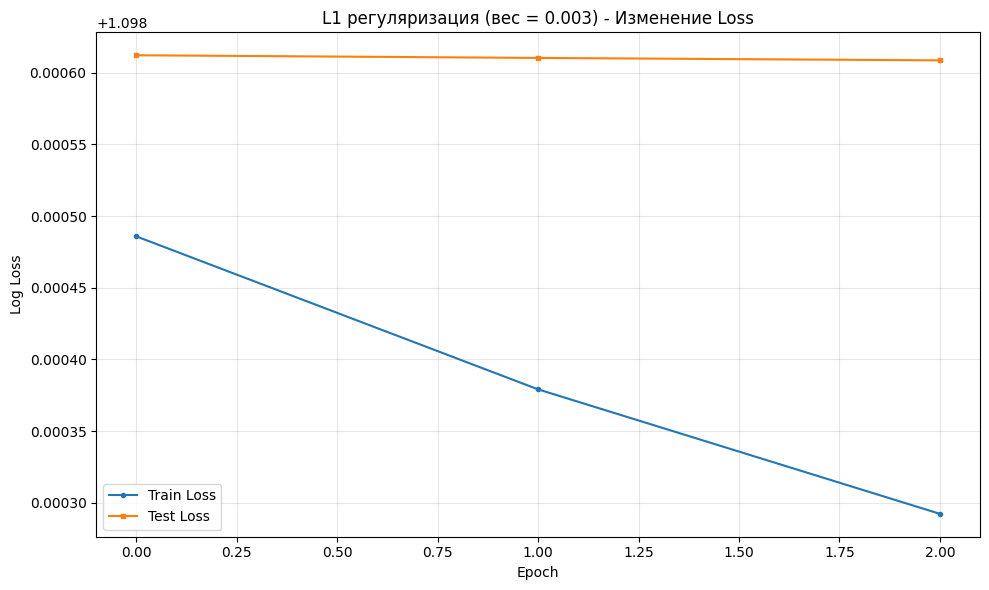


Результаты для вес = 0.003:
Micro Accuracy: 0.3384
Macro Accuracy: 0.5590
Micro F1: 0.3384
Macro F1: 0.2619
Итоговый Train Loss: 1.0983
Итоговый Test Loss: 1.0986
Обучение с L1 регуляризацией, вес = 0.01
Epoch 1: Train Loss = 1.0986, Test Loss = 1.0986
Epoch 2: Train Loss = 1.0986, Test Loss = 1.0986
Сходимость достигнута на эпохе 2


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


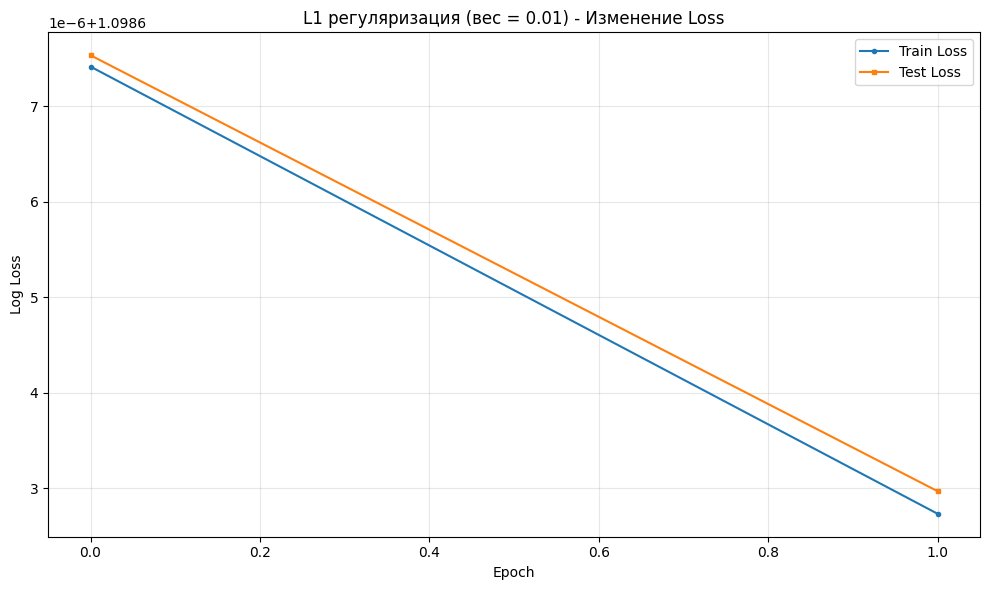


Результаты для вес = 0.01:
Micro Accuracy: 0.3395
Macro Accuracy: 0.5596
Micro F1: 0.3395
Macro F1: 0.1690
Итоговый Train Loss: 1.0986
Итоговый Test Loss: 1.0986
Обучение с L1 регуляризацией, вес = 0.1
Epoch 1: Train Loss = 1.0986, Test Loss = 1.0986
Epoch 2: Train Loss = 1.0986, Test Loss = 1.0986
Сходимость достигнута на эпохе 2


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


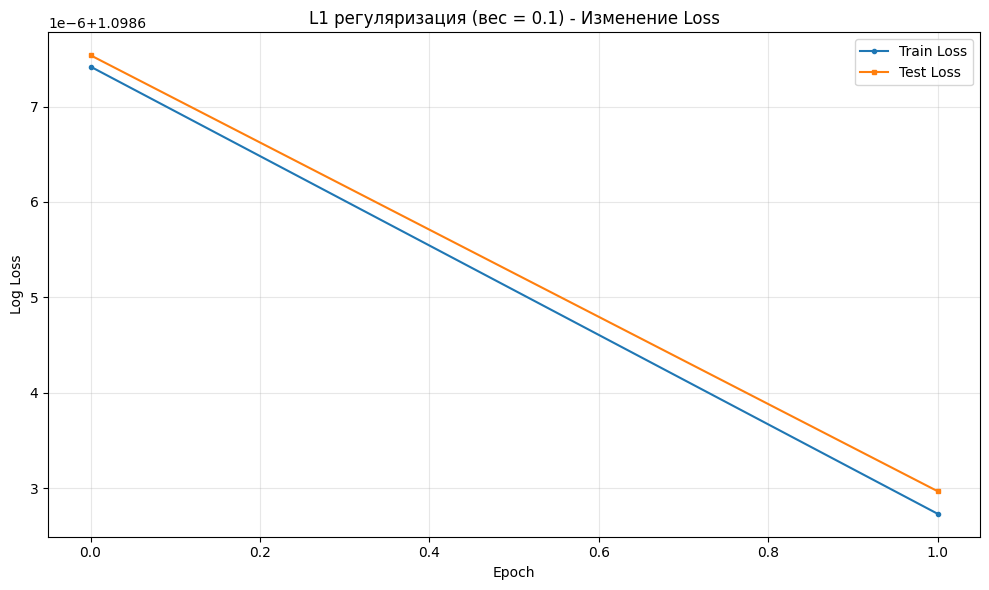


Результаты для вес = 0.1:
Micro Accuracy: 0.3395
Macro Accuracy: 0.5596
Micro F1: 0.3395
Macro F1: 0.1690
Итоговый Train Loss: 1.0986
Итоговый Test Loss: 1.0986


In [ ]:
l1_weights = [0.0001, 0.001, 0.002, 0.0025, 0.003, 0.01, 0.1]
test_micro_accuracy_4 = []
macro_accuracy_test_4 = []
test_micro_f1_4 = []
test_macro_f1_4 = []

for i in l1_weights:
    print(f"Обучение с L1 регуляризацией, вес = {i}")

    l1_sgd_lr = SGDClassifier(loss='log_loss',penalty='l1',alpha=i,max_iter=1,learning_rate='constant',eta0=0.01,random_state=42,warm_start=True,verbose=0)


    X_train_tfidf_4 = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf_4 = tfidf_vectorizer.transform(X_test)


    train_losses_l1 = []
    test_losses_l1 = []

    for epoch in range(100):
        l1_sgd_lr.fit(X_train_tfidf_4, y_train)

        y_pred_proba_train = l1_sgd_lr.predict_proba(X_train_tfidf_4)
        y_pred_proba_test = l1_sgd_lr.predict_proba(X_test_tfidf_4)

        train_loss = log_loss(y_train, y_pred_proba_train)
        test_loss = log_loss(y_test, y_pred_proba_test)

        train_losses_l1.append(train_loss)
        test_losses_l1.append(test_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

        if epoch > 0 and abs(train_losses_l1[-1] - train_losses_l1[-2]) < 1e-4:
            print(f"Сходимость достигнута на эпохе {epoch+1}")
            break

    # Визуализация потерь для текущего веса
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_l1, label='Train Loss', marker='o', markersize=3)
    plt.plot(test_losses_l1, label='Test Loss', marker='s', markersize=3)
    plt.xlabel('Epoch')
    plt.ylabel('Log Loss')
    plt.title(f'L1 регуляризация (вес = {i}) - Изменение Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Предсказания
    y_pred_train_4 = l1_sgd_lr.predict(X_train_tfidf_4)
    y_pred_test_4 = l1_sgd_lr.predict(X_test_tfidf_4)

    # Micro Accuracy
    mic_ac = accuracy_score(y_test, y_pred_test_4)
    test_micro_accuracy_4.append(mic_ac)

    # Macro Accuracy
    mac_ac = macro_accuracy_score(y_test, y_pred_test_4)
    macro_accuracy_test_4.append(mac_ac)

    # Micro F1
    mic_f1 = f1_score(y_test, y_pred_test_4, average='micro')
    test_micro_f1_4.append(mic_f1)

    # Macro F1
    mac_f1 = f1_score(y_test, y_pred_test_4, average='macro')
    test_macro_f1_4.append(mac_f1)

    print(f"\nРезультаты для вес = {i}:")
    print(f"Micro Accuracy: {mic_ac:.4f}")
    print(f"Macro Accuracy: {mac_ac:.4f}")
    print(f"Micro F1: {mic_f1:.4f}")
    print(f"Macro F1: {mac_f1:.4f}")
    print(f"Итоговый Train Loss: {train_losses_l1[-1]:.4f}")
    print(f"Итоговый Test Loss: {test_losses_l1[-1]:.4f}")


In [ ]:
for i in range(len(l1_weights)):
    print(f'\nМодель {i+1}:')
    print(f'Вес L1 : {l1_weights[i]}')
    print(f'Micro Accuracy: {test_micro_accuracy_4[i]:.4f}')
    print(f'Macro Accuracy: {macro_accuracy_test_4[i]:.4f}')
    print(f'Micro F-1: {test_micro_f1_4[i]:.4f}')
    print(f'Macro F-1: {test_macro_f1_4[i]:.4f}')


Модель 1:
Вес L1 : 0.0001
Micro Accuracy: 0.3395
Macro Accuracy: 0.5596
Micro F-1: 0.3395
Macro F-1: 0.3385

Модель 2:
Вес L1 : 0.001
Micro Accuracy: 0.3231
Macro Accuracy: 0.5487
Micro F-1: 0.3231
Macro F-1: 0.3126

Модель 3:
Вес L1 : 0.002
Micro Accuracy: 0.3374
Macro Accuracy: 0.5583
Micro F-1: 0.3374
Macro F-1: 0.3003

Модель 4:
Вес L1 : 0.0025
Micro Accuracy: 0.3344
Macro Accuracy: 0.5562
Micro F-1: 0.3344
Macro F-1: 0.2748

Модель 5:
Вес L1 : 0.003
Micro Accuracy: 0.3384
Macro Accuracy: 0.5590
Micro F-1: 0.3384
Macro F-1: 0.2619

Модель 6:
Вес L1 : 0.01
Micro Accuracy: 0.3395
Macro Accuracy: 0.5596
Micro F-1: 0.3395
Macro F-1: 0.1690

Модель 7:
Вес L1 : 0.1
Micro Accuracy: 0.3395
Macro Accuracy: 0.5596
Micro F-1: 0.3395
Macro F-1: 0.1690


In [ ]:
# Сравниваем лучшие результаты
l1_w = 0.002
l2_w = 0.0001

# Модель с L1 регуляризацией
l1_sgd_lr = SGDClassifier(loss='log_loss',penalty='l1',alpha=l1_w,max_iter=100,learning_rate='constant',eta0=0.01,random_state=42,verbose=0)

# Модель с L2 регуляризацией
l2_sgd_lr = SGDClassifier(loss='log_loss',penalty='l2',alpha=l2_w,max_iter=100,learning_rate='constant',eta0=0.01,random_state=42,verbose=0)

l1_sgd_lr.fit(X_train_tfidf, y_train)
l2_sgd_lr.fit(X_train_tfidf, y_train)

# Веса моделей
l1_coef = l1_sgd_lr.coef_
l2_coef = l2_sgd_lr.coef_

class_names = l1_sgd_lr.classes_
print(f"Названия классов: {class_names}")

print(f"\nСравнение моделей")


feature_names = tfidf_vectorizer.get_feature_names_out()

for class_idx, class_name in enumerate(class_names):
    print(f"\nКласс '{class_name}'")

    # Веса для текущего класса
    l1_weights_class = l1_coef[class_idx]
    l2_weights_class = l2_coef[class_idx]

    # Считаем ненулевые веса
    l1_nonzero = np.sum(l1_weights_class != 0)
    l2_nonzero = np.sum(l2_weights_class != 0)

    print(f"L1 - ненулевых весов: {l1_nonzero} из {len(l1_weights_class)} ({l1_nonzero/len(l1_weights_class)*100:.1f}%)")
    print(f"L2 - ненулевых весов: {l2_nonzero} из {len(l2_weights_class)} ({l2_nonzero/len(l2_weights_class)*100:.1f}%)")

    # Находим веса, которые занулились в L1, но не в L2
    zero_in_l1_but_not_l2 = []

    for idx, (l1_w, l2_w) in enumerate(zip(l1_weights_class, l2_weights_class)):
        if l1_w == 0 and l2_w != 0:
            zero_in_l1_but_not_l2.append((feature_names[idx], l2_w))

    print(f"Занулилось в L1 (но было ненулевым в L2): {len(zero_in_l1_but_not_l2)} n-грамм")

    # 10 самых важных n-грамм, которые занулились в L1
    if zero_in_l1_but_not_l2:
        print("\n10 самых важных n-грамм (по абсолютному значению в L2), которые занулились в L1:")
        zero_in_l1_but_not_l2_sorted = sorted(zero_in_l1_but_not_l2, key=lambda x: abs(x[1]), reverse=True)[:10]

        for i, (feature, weight) in enumerate(zero_in_l1_but_not_l2_sorted):
            print(f"  {i+1}. '{feature}': L2 вес = {weight:.6f}")

total_features = l1_coef.shape[1]
total_weights = l1_coef.shape[0] * l1_coef.shape[1]

l1_total_nonzero = np.sum(l1_coef != 0)
l2_total_nonzero = np.sum(l2_coef != 0)

print(f"Общее количество n-грамм: {total_features}")
print(f"Общее количество весов: {total_weights}")
print(f"L1 - всего ненулевых весов: {l1_total_nonzero} ({l1_total_nonzero/total_weights*100:.1f}%)")
print(f"L2 - всего ненулевых весов: {l2_total_nonzero} ({l2_total_nonzero/total_weights*100:.1f}%)")
print(f"L1 занулило {total_weights - l1_total_nonzero} весов ({100 - l1_total_nonzero/total_weights*100:.1f}%)")

# Анализ самых важных n-грамм, сохранившихся в обеих моделях
print(f"\n 20 самых важных n-грамм, сохранившихся в обеих моделях")


feature_importance_l2 = np.mean(np.abs(l2_coef), axis=0)
feature_importance_l1 = np.mean(np.abs(l1_coef), axis=0)

common_nonzero_indices = np.where((np.any(l1_coef != 0, axis=0) & np.any(l2_coef != 0, axis=0)))[0]

if len(common_nonzero_indices) > 0:
    common_features_with_importance = []
    for idx in common_nonzero_indices:
        l2_imp = feature_importance_l2[idx]
        l1_imp = feature_importance_l1[idx]
        common_features_with_importance.append((feature_names[idx], l2_imp, l1_imp))

    common_features_sorted = sorted(common_features_with_importance, key=lambda x: x[1], reverse=True)[:20]

    print("\nN-грамма             | L2 веса  | L1 веса")
    print("-" * 50)
    for feature, l2_imp, l1_imp in common_features_sorted:
        print(f"{feature:20} | {l2_imp:.6f} | {l1_imp:.6f}")

Названия классов: ['High' 'Low' 'Medium']

Сравнение моделей

Класс 'High'
L1 - ненулевых весов: 30 из 2006 (1.5%)
L2 - ненулевых весов: 2006 из 2006 (100.0%)
Занулилось в L1 (но было ненулевым в L2): 1976 n-грамм

10 самых важных n-грамм (по абсолютному значению в L2), которые занулились в L1:
  1. 'material': L2 вес = 0.492892
  2. 'pharmaceutical': L2 вес = -0.481273
  3. 'seek': L2 вес = -0.478708
  4. 'chain disruption': L2 вес = 0.473728
  5. 'disruption': L2 вес = 0.473728
  6. 'cause': L2 вес = -0.473483
  7. 'moneycontrol': L2 вес = -0.472162
  8. 'moneycontrol com': L2 вес = -0.472162
  9. 'tsx composite': L2 вес = -0.451481
  10. 'neutral energy': L2 вес = -0.442284

Класс 'Low'
L1 - ненулевых весов: 20 из 2006 (1.0%)
L2 - ненулевых весов: 2006 из 2006 (100.0%)
Занулилось в L1 (но было ненулевым в L2): 1986 n-грамм

10 самых важных n-грамм (по абсолютному значению в L2), которые занулились в L1:
  1. 'bond fluctuation': L2 вес = -0.590917
  2. 'bond': L2 вес = -0.582879
  3.

Результаты для L1 с весом = 0.002:

Micro Accuracy: 0.3374;

Macro Accuracy: 0.5583;

Micro F1: 0.3374;

Macro F1: 0.3003;

Итоговый Train Loss: 1.0954;

Итоговый Test Loss: 1.0985.


Результат для L2:

Micro Accuracy: 0.3446;

Macro Accuracy: 0.5631;

Micro F1: 0.3446;

Macro F1: 0.3438;

Итоговый Train Loss: 0.9080;

Итоговый Test Loss: 1.1540.

Видно, что результаты L1 с весом = 0.002 хуже, чем результаты с L2.


Задание 5

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cpu


In [ ]:
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

n_classes = len(label_encoder.classes_)
n_features = X_train_dense.shape[1]

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, init_type='xavier'):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size, num_classes)

        self.init_weights(init_type)

    def init_weights(self, init_type):
        print(f"Применяем инициализацию: {init_type}")

        if init_type == 'zeros':
            nn.init.constant_(self.fc1.weight, 0.0)
            nn.init.constant_(self.fc1.bias, 0.0)
            nn.init.constant_(self.fc2.weight, 0.0)
            nn.init.constant_(self.fc2.bias, 0.0)

        elif init_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.constant_(self.fc1.bias, 0.0)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.constant_(self.fc2.bias, 0.0)

        elif init_type == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.constant_(self.fc1.bias, 0.0)
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.constant_(self.fc2.bias, 0.0)


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [ ]:
hidden_size = 256  # размер скрытого слоя
model = NeuralNetwork(n_features, hidden_size, n_classes).to(device)

Применяем инициализацию: xavier


In [ ]:
init_methods = ['zeros', 'xavier', 'he']
colors = ['red', 'blue', 'green']

In [ ]:
X_train_tensor = torch.FloatTensor(X_train_dense)
y_train_tensor = torch.LongTensor(y_train_encoded)
X_test_tensor = torch.FloatTensor(X_test_dense)
y_test_tensor = torch.LongTensor(y_test_encoded)

In [ ]:
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Применяем инициализацию: zeros
Epoch [10/100], Train Loss: 1.0985, Test Loss: 1.0987, Micro Acc: 0.3395, Macro F1: 0.1690
Epoch [20/100], Train Loss: 1.0986, Test Loss: 1.0987, Micro Acc: 0.3395, Macro F1: 0.1690
Epoch [30/100], Train Loss: 1.0985, Test Loss: 1.0987, Micro Acc: 0.3395, Macro F1: 0.1690
Epoch [40/100], Train Loss: 1.0985, Test Loss: 1.0987, Micro Acc: 0.3395, Macro F1: 0.1690
Epoch [50/100], Train Loss: 1.0986, Test Loss: 1.0987, Micro Acc: 0.3395, Macro F1: 0.1690
Epoch [60/100], Train Loss: 1.0986, Test Loss: 1.0988, Micro Acc: 0.3395, Macro F1: 0.1690
Epoch [70/100], Train Loss: 1.0986, Test Loss: 1.0987, Micro Acc: 0.3395, Macro F1: 0.1690
Epoch [80/100], Train Loss: 1.0985, Test Loss: 1.0987, Micro Acc: 0.3395, Macro F1: 0.1690
Epoch [90/100], Train Loss: 1.0986, Test Loss: 1.0988, Micro Acc: 0.3395, Macro F1: 0.1690
Epoch [100/100], Train Loss: 1.0986, Test Loss: 1.0987, Micro Acc: 0.3395, Macro F1: 0.1690
ZEROS завершена. Final Test Loss: 1.0987, Accuracy: 0.3395

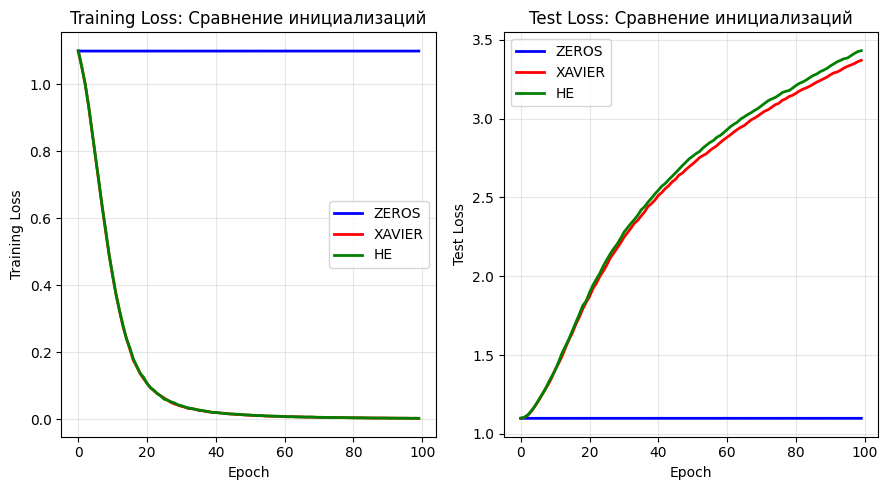

Итоговое сравнение методов инициализации весов:
Method     Test Loss  Micro Acc  Macro Acc  Micro F1   Macro F1  
--------------------------------------------------------------------------------
ZEROS      1.0987     0.3395     0.5596     0.3395     0.1690    
XAVIER     3.3695     0.3405     0.5603     0.3405     0.3398    
HE         3.4303     0.3364     0.5576     0.3364     0.3359    

 Лучший метод по Test Loss: ZEROS (1.0987)
 Лучший метод по Micro Accuracy: XAVIER (0.3405)
 Лучший метод по Macro Accuracy: XAVIER (0.5603)
 Лучший метод по Macro F1: XAVIER (0.3398)


In [ ]:
results = {}
colors = ['blue', 'red', 'green', 'orange', 'purple']

for init_method in init_methods:

    model = NeuralNetwork(input_size=n_features, hidden_size=hidden_size, num_classes=n_classes, init_type=init_method).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    test_micro_accuracies = []
    test_macro_accuracies = []
    test_micro_f1_scores = []
    test_macro_f1_scores = []

    for epoch in range(100):
        model.train()
        epoch_train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_accuracy = train_correct / train_total

        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0

        all_targets = []
        all_predictions = []

        with torch.no_grad():
            for data, targets in test_loader:
                data = data.to(device)
                targets = targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                test_total += targets.size(0)
                test_correct += (predicted == targets).sum().item()

                all_targets.extend(targets.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = test_correct / test_total


        # Micro Accuracy
        micro_accuracy = accuracy_score(all_targets, all_predictions)

        # Macro Accuracy
        def macro_accuracy_score(y_true, y_pred):
            classes = np.unique(np.concatenate([y_true, y_pred]))
            class_accuracies = []
            for class_label in classes:
                mask_true = (y_true == class_label)
                mask_pred = (y_pred == class_label)
                if np.sum(mask_true) > 0:  # избегаем деления на ноль
                    class_accuracy = accuracy_score(mask_true, mask_pred)
                    class_accuracies.append(class_accuracy)
            return np.mean(class_accuracies) if class_accuracies else 0.0

        macro_accuracy = macro_accuracy_score(all_targets, all_predictions)

        # Micro F1 и Macro F1
        micro_f1 = f1_score(all_targets, all_predictions, average='micro', zero_division=0)
        macro_f1 = f1_score(all_targets, all_predictions, average='macro', zero_division=0)

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
        test_micro_accuracies.append(micro_accuracy)
        test_macro_accuracies.append(macro_accuracy)
        test_micro_f1_scores.append(micro_f1)
        test_macro_f1_scores.append(macro_f1)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{100}], '
                  f'Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, '
                  f'Micro Acc: {test_accuracy:.4f}, Macro F1: {macro_f1:.4f}')

    results[init_method] = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'test_micro_accuracies': test_micro_accuracies,
        'test_macro_accuracies': test_macro_accuracies,
        'test_micro_f1_scores': test_micro_f1_scores,
        'test_macro_f1_scores': test_macro_f1_scores,
        'final_train_loss': train_losses[-1],
        'final_test_loss': test_losses[-1],
        'final_test_accuracy': test_accuracies[-1],
        'final_micro_accuracy': test_micro_accuracies[-1],
        'final_macro_accuracy': test_macro_accuracies[-1],
        'final_micro_f1': test_micro_f1_scores[-1],
        'final_macro_f1': test_macro_f1_scores[-1],
        'model': model
    }

    print(f"{init_method.upper()} завершена. Final Test Loss: {test_losses[-1]:.4f}, Accuracy: {test_accuracies[-1]:.4f}")
    print(f"  Micro Accuracy: {test_micro_accuracies[-1]:.4f}, Macro Accuracy: {test_macro_accuracies[-1]:.4f}")
    print(f"  Micro F1: {test_micro_f1_scores[-1]:.4f}, Macro F1: {test_macro_f1_scores[-1]:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(9, 5))

# Сравнение Train Loss
for i, (init_method, color) in enumerate(zip(init_methods, colors)):
    axes[0].plot(results[init_method]['train_losses'],
             label=f'{init_method.upper()}',
             color=color,
             linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss: Сравнение инициализаций')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Сравнение Test Loss
for i, (init_method, color) in enumerate(zip(init_methods, colors)):
    axes[1].plot(results[init_method]['test_losses'],
             label=f'{init_method.upper()}',
             color=color,
             linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Test Loss')
axes[1].set_title('Test Loss: Сравнение инициализаций')
axes[1].legend()
axes[1].grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

# Итоговая таблица сравнения
print("Итоговое сравнение методов инициализации весов:")
print(f"{'Method':<10} {'Test Loss':<10} {'Micro Acc':<10} {'Macro Acc':<10} {'Micro F1':<10} {'Macro F1':<10}")
print("-"*80)
for init_method in init_methods:
    result = results[init_method]
    print(f"{init_method.upper():<10} {result['final_test_loss']:<10.4f} "
          f"{result['final_micro_accuracy']:<10.4f} {result['final_macro_accuracy']:<10.4f} "
          f"{result['final_micro_f1']:<10.4f} {result['final_macro_f1']:<10.4f}")

# Находим лучший метод по разным метрикам
best_by_loss = min(init_methods, key=lambda x: results[x]['final_test_loss'])
best_by_micro_acc = max(init_methods, key=lambda x: results[x]['final_micro_accuracy'])
best_by_macro_acc = max(init_methods, key=lambda x: results[x]['final_macro_accuracy'])
best_by_macro_f1 = max(init_methods, key=lambda x: results[x]['final_macro_f1'])

print(f"\n Лучший метод по Test Loss: {best_by_loss.upper()} ({results[best_by_loss]['final_test_loss']:.4f})")
print(f" Лучший метод по Micro Accuracy: {best_by_micro_acc.upper()} ({results[best_by_micro_acc]['final_micro_accuracy']:.4f})")
print(f" Лучший метод по Macro Accuracy: {best_by_macro_acc.upper()} ({results[best_by_macro_acc]['final_macro_accuracy']:.4f})")
print(f" Лучший метод по Macro F1: {best_by_macro_f1.upper()} ({results[best_by_macro_f1]['final_macro_f1']:.4f})")

Задание 6

Лучший результат (L2):

Micro Accuracy: 0.3446;

Macro Accuracy: 0.5631;

Micro F1: 0.3446;

Macro F1: 0.3438;

Итоговый Train Loss: 0.9080;

Итоговый Test Loss: 1.1540.

Задание 7

In [ ]:
df_an = df_processed.copy()

Добавляем только числовые значения из столбца Trading_Volume


In [ ]:
df_processed['all_text'] = df_processed['all_text'] + ' ' + df_processed['Trading_Volume'].astype(str)

In [ ]:
    # X - признаки (текст)
X = df_processed['all_text']

    # y - целевая переменная (Impact_Level)
y = df_processed['Impact_Level']

print(f"Размер X (all_text): {X.shape}")
print(f"Размер y (Impact_Level): {y.shape}")

print(f"\nРаспределение целевой переменной:")
print(y.value_counts())


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=42,stratify=y)

Размер X (all_text): (2443,)
Размер y (Impact_Level): (2443,)

Распределение целевой переменной:
Impact_Level
Low       829
Medium    813
High      801
Name: count, dtype: int64


Epoch 1: Train Loss = 1.0947, Test Loss = 1.0986
Epoch 2: Train Loss = 1.0907, Test Loss = 1.0985
Epoch 3: Train Loss = 1.0865, Test Loss = 1.0986
Epoch 4: Train Loss = 1.0822, Test Loss = 1.0986
Epoch 5: Train Loss = 1.0780, Test Loss = 1.0988


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 6: Train Loss = 1.0738, Test Loss = 1.0989
Epoch 7: Train Loss = 1.0696, Test Loss = 1.0991
Epoch 8: Train Loss = 1.0655, Test Loss = 1.0994
Epoch 9: Train Loss = 1.0615, Test Loss = 1.0997
Epoch 10: Train Loss = 1.0575, Test Loss = 1.1000
Epoch 11: Train Loss = 1.0537, Test Loss = 1.1003
Epoch 12: Train Loss = 1.0499, Test Loss = 1.1007
Epoch 13: Train Loss = 1.0462, Test Loss = 1.1011
Epoch 14: Train Loss = 1.0426, Test Loss = 1.1016
Epoch 15: Train Loss = 1.0391, Test Loss = 1.1020
Epoch 16: Train Loss = 1.0356, Test Loss = 1.1025
Epoch 17: Train Loss = 1.0323, Test Loss = 1.1030
Epoch 18: Train Loss = 1.0290, Test Loss = 1.1035


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 19: Train Loss = 1.0258, Test Loss = 1.1040
Epoch 20: Train Loss = 1.0227, Test Loss = 1.1045
Epoch 21: Train Loss = 1.0196, Test Loss = 1.1051
Epoch 22: Train Loss = 1.0166, Test Loss = 1.1056
Epoch 23: Train Loss = 1.0137, Test Loss = 1.1062
Epoch 24: Train Loss = 1.0108, Test Loss = 1.1068
Epoch 25: Train Loss = 1.0080, Test Loss = 1.1074
Epoch 26: Train Loss = 1.0053, Test Loss = 1.1080
Epoch 27: Train Loss = 1.0026, Test Loss = 1.1085
Epoch 28: Train Loss = 1.0000, Test Loss = 1.1091
Epoch 29: Train Loss = 0.9974, Test Loss = 1.1097
Epoch 30: Train Loss = 0.9948, Test Loss = 1.1104
Epoch 31: Train Loss = 0.9924, Test Loss = 1.1110
Epoch 32: Train Loss = 0.9899, Test Loss = 1.1116
Epoch 33: Train Loss = 0.9875, Test Loss = 1.1122


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 34: Train Loss = 0.9851, Test Loss = 1.1128
Epoch 35: Train Loss = 0.9828, Test Loss = 1.1134
Epoch 36: Train Loss = 0.9805, Test Loss = 1.1140
Epoch 37: Train Loss = 0.9783, Test Loss = 1.1147
Epoch 38: Train Loss = 0.9761, Test Loss = 1.1153
Epoch 39: Train Loss = 0.9739, Test Loss = 1.1159
Epoch 40: Train Loss = 0.9718, Test Loss = 1.1165
Epoch 41: Train Loss = 0.9697, Test Loss = 1.1171
Epoch 42: Train Loss = 0.9676, Test Loss = 1.1177
Epoch 43: Train Loss = 0.9655, Test Loss = 1.1184
Epoch 44: Train Loss = 0.9635, Test Loss = 1.1190
Epoch 45: Train Loss = 0.9615, Test Loss = 1.1196
Epoch 46: Train Loss = 0.9596, Test Loss = 1.1202
Epoch 47: Train Loss = 0.9576, Test Loss = 1.1208


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 48: Train Loss = 0.9557, Test Loss = 1.1214
Epoch 49: Train Loss = 0.9538, Test Loss = 1.1220
Epoch 50: Train Loss = 0.9520, Test Loss = 1.1226
Epoch 51: Train Loss = 0.9501, Test Loss = 1.1232
Epoch 52: Train Loss = 0.9483, Test Loss = 1.1238
Epoch 53: Train Loss = 0.9465, Test Loss = 1.1244
Epoch 54: Train Loss = 0.9447, Test Loss = 1.1249
Epoch 55: Train Loss = 0.9430, Test Loss = 1.1255
Epoch 56: Train Loss = 0.9413, Test Loss = 1.1261
Epoch 57: Train Loss = 0.9396, Test Loss = 1.1267
Epoch 58: Train Loss = 0.9379, Test Loss = 1.1273
Epoch 59: Train Loss = 0.9362, Test Loss = 1.1278
Epoch 60: Train Loss = 0.9345, Test Loss = 1.1284
Epoch 61: Train Loss = 0.9329, Test Loss = 1.1290


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 62: Train Loss = 0.9313, Test Loss = 1.1295
Epoch 63: Train Loss = 0.9297, Test Loss = 1.1301
Epoch 64: Train Loss = 0.9281, Test Loss = 1.1306
Epoch 65: Train Loss = 0.9265, Test Loss = 1.1312
Epoch 66: Train Loss = 0.9250, Test Loss = 1.1317
Epoch 67: Train Loss = 0.9234, Test Loss = 1.1322
Epoch 68: Train Loss = 0.9219, Test Loss = 1.1328
Epoch 69: Train Loss = 0.9204, Test Loss = 1.1333
Epoch 70: Train Loss = 0.9189, Test Loss = 1.1338
Epoch 71: Train Loss = 0.9174, Test Loss = 1.1344
Epoch 72: Train Loss = 0.9160, Test Loss = 1.1349
Epoch 73: Train Loss = 0.9145, Test Loss = 1.1354
Epoch 74: Train Loss = 0.9131, Test Loss = 1.1359
Epoch 75: Train Loss = 0.9117, Test Loss = 1.1364
Epoch 76: Train Loss = 0.9103, Test Loss = 1.1369


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 77: Train Loss = 0.9089, Test Loss = 1.1374
Epoch 78: Train Loss = 0.9075, Test Loss = 1.1379
Epoch 79: Train Loss = 0.9061, Test Loss = 1.1384
Epoch 80: Train Loss = 0.9047, Test Loss = 1.1389
Epoch 81: Train Loss = 0.9034, Test Loss = 1.1394
Epoch 82: Train Loss = 0.9021, Test Loss = 1.1399
Epoch 83: Train Loss = 0.9007, Test Loss = 1.1404
Epoch 84: Train Loss = 0.8994, Test Loss = 1.1409
Epoch 85: Train Loss = 0.8981, Test Loss = 1.1413
Epoch 86: Train Loss = 0.8968, Test Loss = 1.1418
Epoch 87: Train Loss = 0.8955, Test Loss = 1.1423
Epoch 88: Train Loss = 0.8943, Test Loss = 1.1428
Epoch 89: Train Loss = 0.8930, Test Loss = 1.1432
Epoch 90: Train Loss = 0.8917, Test Loss = 1.1437


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 91: Train Loss = 0.8905, Test Loss = 1.1441
Epoch 92: Train Loss = 0.8893, Test Loss = 1.1446
Epoch 93: Train Loss = 0.8880, Test Loss = 1.1450
Epoch 94: Train Loss = 0.8868, Test Loss = 1.1455
Epoch 95: Train Loss = 0.8856, Test Loss = 1.1459
Epoch 96: Train Loss = 0.8844, Test Loss = 1.1464
Epoch 97: Train Loss = 0.8832, Test Loss = 1.1468
Epoch 98: Train Loss = 0.8820, Test Loss = 1.1472
Epoch 99: Train Loss = 0.8809, Test Loss = 1.1477
Epoch 100: Train Loss = 0.8797, Test Loss = 1.1481


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


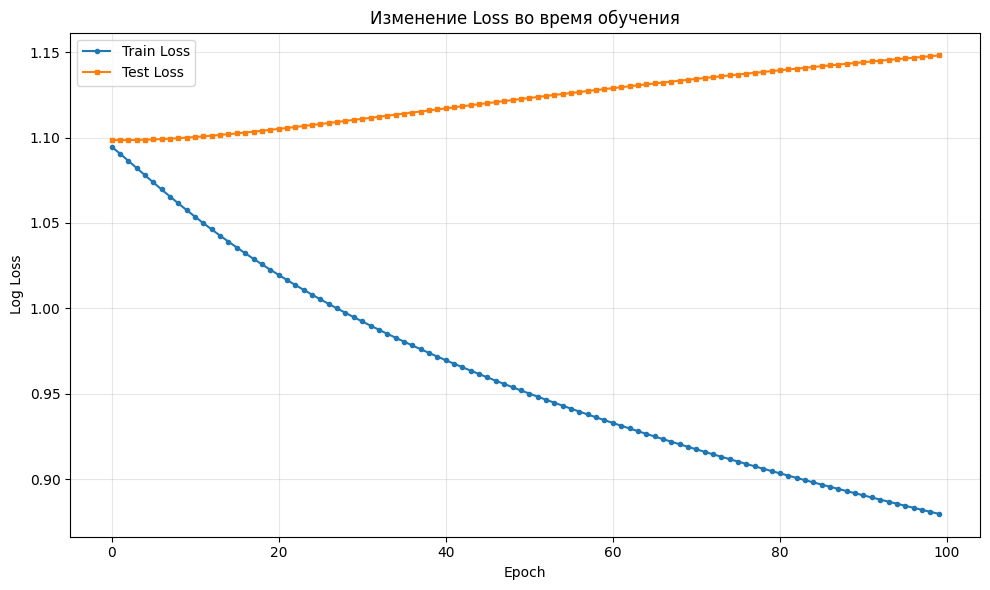

Micro Accuracy: 0.3323
Macro Accuracy: 0.5549
Micro F1: 0.3323
Macro F1: 0.3313

Итоговый Train Loss: 0.8797
Итоговый Test Loss: 1.1481


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,min_df=2,max_df=0.85,ngram_range=(1, 2),stop_words='english',lowercase=True,strip_accents='unicode',analyzer='word')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


sgd_lr = SGDClassifier(loss='log_loss',penalty='l2',alpha=0.0001,max_iter=1,learning_rate='constant',eta0=0.01,random_state=42,warm_start=True,verbose=0)

train_losses = []
test_losses = []


for epoch in range(100):

    sgd_lr.fit(X_train_tfidf, y_train)

    y_pred_proba_train = sgd_lr.predict_proba(X_train_tfidf)
    y_pred_proba_test = sgd_lr.predict_proba(X_test_tfidf)

    train_loss = log_loss(y_train, y_pred_proba_train)
    test_loss = log_loss(y_test, y_pred_proba_test)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

    if epoch > 0 and abs(train_losses[-1] - train_losses[-2]) < 1e-4:
        print(f"Сходимость достигнута на эпохе {epoch+1}")
        break


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o', markersize=3)
plt.plot(test_losses, label='Test Loss', marker='s', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Изменение Loss во время обучения')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


y_pred_train = sgd_lr.predict(X_train_tfidf)
y_pred_test = sgd_lr.predict(X_test_tfidf)

# Micro Accuracy
test_micro_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Micro Accuracy: {test_micro_accuracy:.4f}')

# Macro Accuracy
def macro_accuracy_score(y_true, y_pred):
    classes = np.unique(np.concatenate([y_true, y_pred]))
    class_accuracies = []

    for class_label in classes:
        y_true_binary = (y_true == class_label)
        y_pred_binary = (y_pred == class_label)
        class_accuracy = accuracy_score(y_true_binary, y_pred_binary)
        class_accuracies.append(class_accuracy)

    return np.mean(class_accuracies)

macro_accuracy_test = macro_accuracy_score(y_test, y_pred_test)
print(f"Macro Accuracy: {macro_accuracy_test:.4f}")

# Micro и Macro F1
test_micro_f1 = f1_score(y_test, y_pred_test, average='micro')
test_macro_f1 = f1_score(y_test, y_pred_test, average='macro')
print(f'Micro F1: {test_micro_f1:.4f}')
print(f'Macro F1: {test_macro_f1:.4f}')

print(f"\nИтоговый Train Loss: {train_losses[-1]:.4f}")
print(f"Итоговый Test Loss: {test_losses[-1]:.4f}")

Хуже, чем было в задании 3.

Добавляем еще значения из столбца Index_Change_Percent

In [ ]:
df_processed['all_text'] = df_processed['all_text'] + ' ' + df_processed['Index_Change_Percent'].astype(str)

In [ ]:
    # X - признаки (текст)
X = df_processed['all_text']

    # y - целевая переменная (Impact_Level)
y = df_processed['Impact_Level']

print(f"Размер X (all_text): {X.shape}")
print(f"Размер y (Impact_Level): {y.shape}")

print(f"\nРаспределение целевой переменной:")
print(y.value_counts())


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=42,stratify=y)

Размер X (all_text): (2443,)
Размер y (Impact_Level): (2443,)

Распределение целевой переменной:
Impact_Level
Low       829
Medium    813
High      801
Name: count, dtype: int64


Epoch 1: Train Loss = 1.0948, Test Loss = 1.0985
Epoch 2: Train Loss = 1.0907, Test Loss = 1.0985
Epoch 3: Train Loss = 1.0866, Test Loss = 1.0985
Epoch 4: Train Loss = 1.0823, Test Loss = 1.0986
Epoch 5: Train Loss = 1.0781, Test Loss = 1.0987


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 6: Train Loss = 1.0739, Test Loss = 1.0988
Epoch 7: Train Loss = 1.0698, Test Loss = 1.0990
Epoch 8: Train Loss = 1.0657, Test Loss = 1.0992
Epoch 9: Train Loss = 1.0616, Test Loss = 1.0995
Epoch 10: Train Loss = 1.0577, Test Loss = 1.0998
Epoch 11: Train Loss = 1.0538, Test Loss = 1.1001
Epoch 12: Train Loss = 1.0500, Test Loss = 1.1004
Epoch 13: Train Loss = 1.0463, Test Loss = 1.1008
Epoch 14: Train Loss = 1.0427, Test Loss = 1.1012
Epoch 15: Train Loss = 1.0392, Test Loss = 1.1016
Epoch 16: Train Loss = 1.0357, Test Loss = 1.1021
Epoch 17: Train Loss = 1.0323, Test Loss = 1.1026
Epoch 18: Train Loss = 1.0291, Test Loss = 1.1030
Epoch 19: Train Loss = 1.0258, Test Loss = 1.1035
Epoch 20: Train Loss = 1.0227, Test Loss = 1.1040


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 21: Train Loss = 1.0196, Test Loss = 1.1046
Epoch 22: Train Loss = 1.0166, Test Loss = 1.1051
Epoch 23: Train Loss = 1.0136, Test Loss = 1.1056
Epoch 24: Train Loss = 1.0108, Test Loss = 1.1062
Epoch 25: Train Loss = 1.0079, Test Loss = 1.1067
Epoch 26: Train Loss = 1.0052, Test Loss = 1.1073
Epoch 27: Train Loss = 1.0024, Test Loss = 1.1079
Epoch 28: Train Loss = 0.9998, Test Loss = 1.1085
Epoch 29: Train Loss = 0.9972, Test Loss = 1.1090
Epoch 30: Train Loss = 0.9946, Test Loss = 1.1096
Epoch 31: Train Loss = 0.9921, Test Loss = 1.1102
Epoch 32: Train Loss = 0.9896, Test Loss = 1.1108
Epoch 33: Train Loss = 0.9872, Test Loss = 1.1114


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 34: Train Loss = 0.9848, Test Loss = 1.1120
Epoch 35: Train Loss = 0.9824, Test Loss = 1.1126
Epoch 36: Train Loss = 0.9801, Test Loss = 1.1132
Epoch 37: Train Loss = 0.9779, Test Loss = 1.1138
Epoch 38: Train Loss = 0.9756, Test Loss = 1.1144
Epoch 39: Train Loss = 0.9734, Test Loss = 1.1150
Epoch 40: Train Loss = 0.9712, Test Loss = 1.1156
Epoch 41: Train Loss = 0.9691, Test Loss = 1.1162
Epoch 42: Train Loss = 0.9670, Test Loss = 1.1168
Epoch 43: Train Loss = 0.9649, Test Loss = 1.1174
Epoch 44: Train Loss = 0.9629, Test Loss = 1.1180
Epoch 45: Train Loss = 0.9609, Test Loss = 1.1186
Epoch 46: Train Loss = 0.9589, Test Loss = 1.1192
Epoch 47: Train Loss = 0.9569, Test Loss = 1.1198


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 48: Train Loss = 0.9550, Test Loss = 1.1204
Epoch 49: Train Loss = 0.9531, Test Loss = 1.1210
Epoch 50: Train Loss = 0.9512, Test Loss = 1.1216
Epoch 51: Train Loss = 0.9493, Test Loss = 1.1221
Epoch 52: Train Loss = 0.9475, Test Loss = 1.1227
Epoch 53: Train Loss = 0.9456, Test Loss = 1.1233
Epoch 54: Train Loss = 0.9438, Test Loss = 1.1239
Epoch 55: Train Loss = 0.9421, Test Loss = 1.1245
Epoch 56: Train Loss = 0.9403, Test Loss = 1.1250
Epoch 57: Train Loss = 0.9386, Test Loss = 1.1256
Epoch 58: Train Loss = 0.9368, Test Loss = 1.1262
Epoch 59: Train Loss = 0.9351, Test Loss = 1.1267
Epoch 60: Train Loss = 0.9335, Test Loss = 1.1273
Epoch 61: Train Loss = 0.9318, Test Loss = 1.1279


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 62: Train Loss = 0.9302, Test Loss = 1.1284
Epoch 63: Train Loss = 0.9285, Test Loss = 1.1290
Epoch 64: Train Loss = 0.9269, Test Loss = 1.1295
Epoch 65: Train Loss = 0.9253, Test Loss = 1.1301
Epoch 66: Train Loss = 0.9237, Test Loss = 1.1306
Epoch 67: Train Loss = 0.9222, Test Loss = 1.1311
Epoch 68: Train Loss = 0.9206, Test Loss = 1.1317
Epoch 69: Train Loss = 0.9191, Test Loss = 1.1322
Epoch 70: Train Loss = 0.9176, Test Loss = 1.1327
Epoch 71: Train Loss = 0.9161, Test Loss = 1.1332
Epoch 72: Train Loss = 0.9146, Test Loss = 1.1338
Epoch 73: Train Loss = 0.9131, Test Loss = 1.1343
Epoch 74: Train Loss = 0.9117, Test Loss = 1.1348
Epoch 75: Train Loss = 0.9102, Test Loss = 1.1353
Epoch 76: Train Loss = 0.9088, Test Loss = 1.1358


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 77: Train Loss = 0.9074, Test Loss = 1.1363
Epoch 78: Train Loss = 0.9060, Test Loss = 1.1368
Epoch 79: Train Loss = 0.9046, Test Loss = 1.1373
Epoch 80: Train Loss = 0.9032, Test Loss = 1.1378
Epoch 81: Train Loss = 0.9018, Test Loss = 1.1383
Epoch 82: Train Loss = 0.9004, Test Loss = 1.1388
Epoch 83: Train Loss = 0.8991, Test Loss = 1.1393
Epoch 84: Train Loss = 0.8978, Test Loss = 1.1398
Epoch 85: Train Loss = 0.8964, Test Loss = 1.1402
Epoch 86: Train Loss = 0.8951, Test Loss = 1.1407
Epoch 87: Train Loss = 0.8938, Test Loss = 1.1412
Epoch 88: Train Loss = 0.8925, Test Loss = 1.1417
Epoch 89: Train Loss = 0.8912, Test Loss = 1.1421
Epoch 90: Train Loss = 0.8899, Test Loss = 1.1426
Epoch 91: Train Loss = 0.8887, Test Loss = 1.1431


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 92: Train Loss = 0.8874, Test Loss = 1.1435
Epoch 93: Train Loss = 0.8862, Test Loss = 1.1440
Epoch 94: Train Loss = 0.8849, Test Loss = 1.1444
Epoch 95: Train Loss = 0.8837, Test Loss = 1.1449
Epoch 96: Train Loss = 0.8825, Test Loss = 1.1453
Epoch 97: Train Loss = 0.8813, Test Loss = 1.1458
Epoch 98: Train Loss = 0.8801, Test Loss = 1.1462
Epoch 99: Train Loss = 0.8789, Test Loss = 1.1466
Epoch 100: Train Loss = 0.8777, Test Loss = 1.1471


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


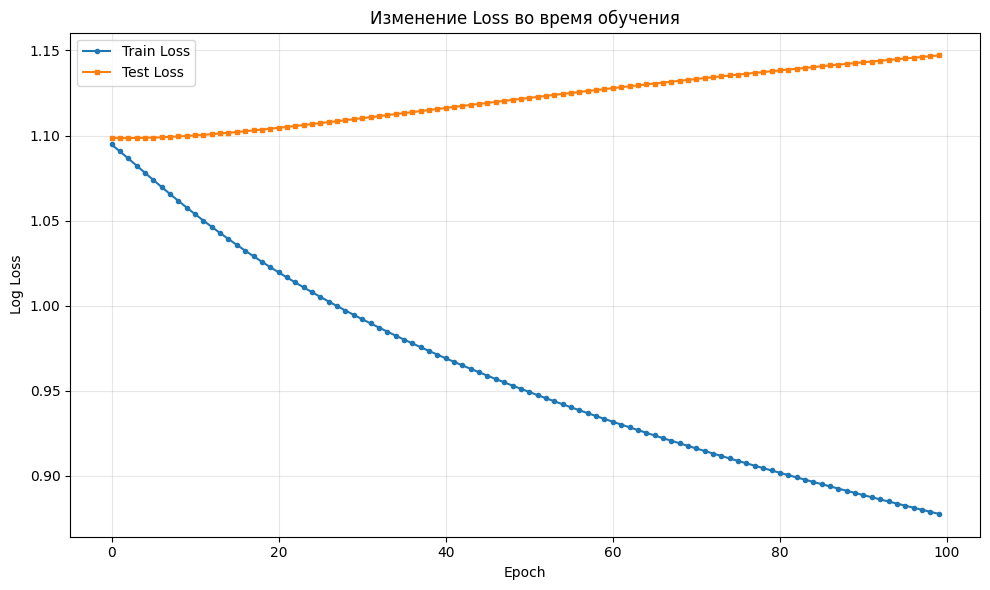

Micro Accuracy: 0.3456
Macro Accuracy: 0.5637
Micro F1: 0.3456
Macro F1: 0.3447

Итоговый Train Loss: 0.8777
Итоговый Test Loss: 1.1471


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,min_df=2,max_df=0.85,ngram_range=(1, 2),stop_words='english',lowercase=True,strip_accents='unicode',analyzer='word')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


sgd_lr = SGDClassifier(loss='log_loss',penalty='l2',alpha=0.0001,max_iter=1,learning_rate='constant',eta0=0.01,random_state=42,warm_start=True,verbose=0)

train_losses = []
test_losses = []


for epoch in range(100):

    sgd_lr.fit(X_train_tfidf, y_train)

    y_pred_proba_train = sgd_lr.predict_proba(X_train_tfidf)
    y_pred_proba_test = sgd_lr.predict_proba(X_test_tfidf)

    train_loss = log_loss(y_train, y_pred_proba_train)
    test_loss = log_loss(y_test, y_pred_proba_test)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

    if epoch > 0 and abs(train_losses[-1] - train_losses[-2]) < 1e-4:
        print(f"Сходимость достигнута на эпохе {epoch+1}")
        break


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o', markersize=3)
plt.plot(test_losses, label='Test Loss', marker='s', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Изменение Loss во время обучения')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


y_pred_train = sgd_lr.predict(X_train_tfidf)
y_pred_test = sgd_lr.predict(X_test_tfidf)

# Micro Accuracy
test_micro_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Micro Accuracy: {test_micro_accuracy:.4f}')

# Macro Accuracy
def macro_accuracy_score(y_true, y_pred):
    classes = np.unique(np.concatenate([y_true, y_pred]))
    class_accuracies = []

    for class_label in classes:
        y_true_binary = (y_true == class_label)
        y_pred_binary = (y_pred == class_label)
        class_accuracy = accuracy_score(y_true_binary, y_pred_binary)
        class_accuracies.append(class_accuracy)

    return np.mean(class_accuracies)

macro_accuracy_test = macro_accuracy_score(y_test, y_pred_test)
print(f"Macro Accuracy: {macro_accuracy_test:.4f}")

# Micro и Macro F1
test_micro_f1 = f1_score(y_test, y_pred_test, average='micro')
test_macro_f1 = f1_score(y_test, y_pred_test, average='macro')
print(f'Micro F1: {test_micro_f1:.4f}')
print(f'Macro F1: {test_macro_f1:.4f}')

print(f"\nИтоговый Train Loss: {train_losses[-1]:.4f}")
print(f"Итоговый Test Loss: {test_losses[-1]:.4f}")

Результат превзошел результат, полученный в задании 3.

Теперь к столбцу all_text из задания 3 добавим числовые значения только из столбца Index_Change_Percent

In [ ]:
df_an['all_text'] = df_an['all_text'] + ' ' + df_an['Index_Change_Percent'].astype(str)

In [ ]:
    # X - признаки (текст)
X = df_an['all_text']

    # y - целевая переменная (Impact_Level)
y = df_an['Impact_Level']

print(f"Размер X (all_text): {X.shape}")
print(f"Размер y (Impact_Level): {y.shape}")

print(f"\nРаспределение целевой переменной:")
print(y.value_counts())


X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.4,
        random_state=42,
        stratify=y  # Сохраняем распределение классов
    )


Размер X (all_text): (2443,)
Размер y (Impact_Level): (2443,)

Распределение целевой переменной:
Impact_Level
Low       829
Medium    813
High      801
Name: count, dtype: int64


Epoch 1: Train Loss = 1.0947, Test Loss = 1.0985
Epoch 2: Train Loss = 1.0906, Test Loss = 1.0985
Epoch 3: Train Loss = 1.0864, Test Loss = 1.0985
Epoch 4: Train Loss = 1.0822, Test Loss = 1.0985
Epoch 5: Train Loss = 1.0779, Test Loss = 1.0987
Epoch 6: Train Loss = 1.0737, Test Loss = 1.0988


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 7: Train Loss = 1.0696, Test Loss = 1.0990
Epoch 8: Train Loss = 1.0656, Test Loss = 1.0993
Epoch 9: Train Loss = 1.0616, Test Loss = 1.0996
Epoch 10: Train Loss = 1.0578, Test Loss = 1.0999
Epoch 11: Train Loss = 1.0540, Test Loss = 1.1003
Epoch 12: Train Loss = 1.0503, Test Loss = 1.1007
Epoch 13: Train Loss = 1.0468, Test Loss = 1.1011
Epoch 14: Train Loss = 1.0433, Test Loss = 1.1016
Epoch 15: Train Loss = 1.0399, Test Loss = 1.1020
Epoch 16: Train Loss = 1.0366, Test Loss = 1.1025
Epoch 17: Train Loss = 1.0334, Test Loss = 1.1031
Epoch 18: Train Loss = 1.0303, Test Loss = 1.1036
Epoch 19: Train Loss = 1.0273, Test Loss = 1.1041
Epoch 20: Train Loss = 1.0243, Test Loss = 1.1047
Epoch 21: Train Loss = 1.0214, Test Loss = 1.1053


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 22: Train Loss = 1.0186, Test Loss = 1.1059
Epoch 23: Train Loss = 1.0159, Test Loss = 1.1065
Epoch 24: Train Loss = 1.0132, Test Loss = 1.1071
Epoch 25: Train Loss = 1.0106, Test Loss = 1.1077
Epoch 26: Train Loss = 1.0080, Test Loss = 1.1083
Epoch 27: Train Loss = 1.0055, Test Loss = 1.1089
Epoch 28: Train Loss = 1.0030, Test Loss = 1.1096
Epoch 29: Train Loss = 1.0006, Test Loss = 1.1102
Epoch 30: Train Loss = 0.9983, Test Loss = 1.1109
Epoch 31: Train Loss = 0.9960, Test Loss = 1.1115
Epoch 32: Train Loss = 0.9937, Test Loss = 1.1121
Epoch 33: Train Loss = 0.9915, Test Loss = 1.1128
Epoch 34: Train Loss = 0.9894, Test Loss = 1.1134
Epoch 35: Train Loss = 0.9872, Test Loss = 1.1141
Epoch 36: Train Loss = 0.9851, Test Loss = 1.1147


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 37: Train Loss = 0.9831, Test Loss = 1.1154
Epoch 38: Train Loss = 0.9811, Test Loss = 1.1160
Epoch 39: Train Loss = 0.9791, Test Loss = 1.1167
Epoch 40: Train Loss = 0.9771, Test Loss = 1.1173
Epoch 41: Train Loss = 0.9752, Test Loss = 1.1179
Epoch 42: Train Loss = 0.9733, Test Loss = 1.1186
Epoch 43: Train Loss = 0.9714, Test Loss = 1.1192
Epoch 44: Train Loss = 0.9696, Test Loss = 1.1199
Epoch 45: Train Loss = 0.9678, Test Loss = 1.1205
Epoch 46: Train Loss = 0.9660, Test Loss = 1.1211
Epoch 47: Train Loss = 0.9643, Test Loss = 1.1218
Epoch 48: Train Loss = 0.9626, Test Loss = 1.1224
Epoch 49: Train Loss = 0.9609, Test Loss = 1.1230


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 50: Train Loss = 0.9592, Test Loss = 1.1236
Epoch 51: Train Loss = 0.9575, Test Loss = 1.1242
Epoch 52: Train Loss = 0.9559, Test Loss = 1.1249
Epoch 53: Train Loss = 0.9543, Test Loss = 1.1255
Epoch 54: Train Loss = 0.9527, Test Loss = 1.1261
Epoch 55: Train Loss = 0.9511, Test Loss = 1.1267
Epoch 56: Train Loss = 0.9496, Test Loss = 1.1273
Epoch 57: Train Loss = 0.9481, Test Loss = 1.1279
Epoch 58: Train Loss = 0.9466, Test Loss = 1.1285
Epoch 59: Train Loss = 0.9451, Test Loss = 1.1290
Epoch 60: Train Loss = 0.9436, Test Loss = 1.1296
Epoch 61: Train Loss = 0.9421, Test Loss = 1.1302
Epoch 62: Train Loss = 0.9407, Test Loss = 1.1308
Epoch 63: Train Loss = 0.9393, Test Loss = 1.1313
Epoch 64: Train Loss = 0.9379, Test Loss = 1.1319


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 65: Train Loss = 0.9365, Test Loss = 1.1325
Epoch 66: Train Loss = 0.9351, Test Loss = 1.1330
Epoch 67: Train Loss = 0.9337, Test Loss = 1.1336
Epoch 68: Train Loss = 0.9324, Test Loss = 1.1341
Epoch 69: Train Loss = 0.9311, Test Loss = 1.1347
Epoch 70: Train Loss = 0.9298, Test Loss = 1.1352
Epoch 71: Train Loss = 0.9285, Test Loss = 1.1358
Epoch 72: Train Loss = 0.9272, Test Loss = 1.1363
Epoch 73: Train Loss = 0.9259, Test Loss = 1.1368
Epoch 74: Train Loss = 0.9246, Test Loss = 1.1374
Epoch 75: Train Loss = 0.9234, Test Loss = 1.1379
Epoch 76: Train Loss = 0.9221, Test Loss = 1.1384
Epoch 77: Train Loss = 0.9209, Test Loss = 1.1389
Epoch 78: Train Loss = 0.9197, Test Loss = 1.1394
Epoch 79: Train Loss = 0.9185, Test Loss = 1.1399


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 80: Train Loss = 0.9173, Test Loss = 1.1404
Epoch 81: Train Loss = 0.9161, Test Loss = 1.1409
Epoch 82: Train Loss = 0.9149, Test Loss = 1.1414
Epoch 83: Train Loss = 0.9138, Test Loss = 1.1419
Epoch 84: Train Loss = 0.9126, Test Loss = 1.1424
Epoch 85: Train Loss = 0.9115, Test Loss = 1.1429
Epoch 86: Train Loss = 0.9103, Test Loss = 1.1434
Epoch 87: Train Loss = 0.9092, Test Loss = 1.1439
Epoch 88: Train Loss = 0.9081, Test Loss = 1.1443
Epoch 89: Train Loss = 0.9070, Test Loss = 1.1448
Epoch 90: Train Loss = 0.9059, Test Loss = 1.1453
Epoch 91: Train Loss = 0.9048, Test Loss = 1.1457
Epoch 92: Train Loss = 0.9037, Test Loss = 1.1462
Epoch 93: Train Loss = 0.9027, Test Loss = 1.1466
Epoch 94: Train Loss = 0.9016, Test Loss = 1.1471


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic

Epoch 95: Train Loss = 0.9006, Test Loss = 1.1475
Epoch 96: Train Loss = 0.8995, Test Loss = 1.1480
Epoch 97: Train Loss = 0.8985, Test Loss = 1.1484
Epoch 98: Train Loss = 0.8975, Test Loss = 1.1489
Epoch 99: Train Loss = 0.8965, Test Loss = 1.1493
Epoch 100: Train Loss = 0.8954, Test Loss = 1.1497


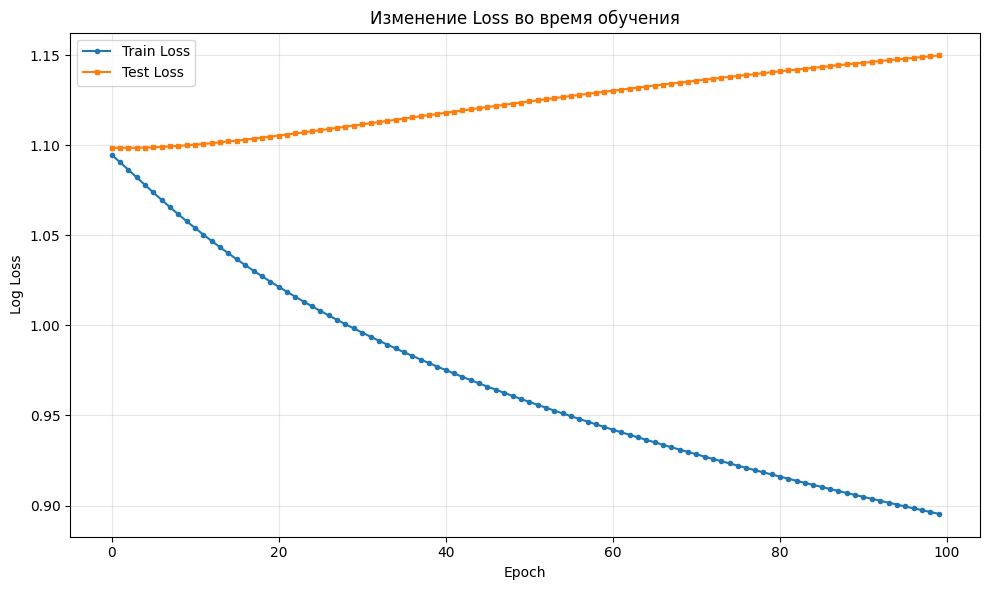

Micro Accuracy: 0.3405
Macro Accuracy: 0.5603
Micro F1: 0.3405
Macro F1: 0.3393

Итоговый Train Loss: 0.8954
Итоговый Test Loss: 1.1497


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,min_df=2,max_df=0.85,ngram_range=(1, 2),stop_words='english',lowercase=True,strip_accents='unicode',analyzer='word')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


sgd_lr = SGDClassifier(loss='log_loss',penalty='l2',alpha=0.0001,max_iter=1,learning_rate='constant',eta0=0.01,random_state=42,warm_start=True,verbose=0)

train_losses = []
test_losses = []


for epoch in range(100):

    sgd_lr.fit(X_train_tfidf, y_train)

    y_pred_proba_train = sgd_lr.predict_proba(X_train_tfidf)
    y_pred_proba_test = sgd_lr.predict_proba(X_test_tfidf)

    train_loss = log_loss(y_train, y_pred_proba_train)
    test_loss = log_loss(y_test, y_pred_proba_test)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

    if epoch > 0 and abs(train_losses[-1] - train_losses[-2]) < 1e-4:
        print(f"Сходимость достигнута на эпохе {epoch+1}")
        break


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o', markersize=3)
plt.plot(test_losses, label='Test Loss', marker='s', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Изменение Loss во время обучения')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


y_pred_train = sgd_lr.predict(X_train_tfidf)
y_pred_test = sgd_lr.predict(X_test_tfidf)

# Micro Accuracy
test_micro_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Micro Accuracy: {test_micro_accuracy:.4f}')

# Macro Accuracy
def macro_accuracy_score(y_true, y_pred):
    classes = np.unique(np.concatenate([y_true, y_pred]))
    class_accuracies = []

    for class_label in classes:
        y_true_binary = (y_true == class_label)
        y_pred_binary = (y_pred == class_label)
        class_accuracy = accuracy_score(y_true_binary, y_pred_binary)
        class_accuracies.append(class_accuracy)

    return np.mean(class_accuracies)

macro_accuracy_test = macro_accuracy_score(y_test, y_pred_test)
print(f"Macro Accuracy: {macro_accuracy_test:.4f}")

# Micro и Macro F1
test_micro_f1 = f1_score(y_test, y_pred_test, average='micro')
test_macro_f1 = f1_score(y_test, y_pred_test, average='macro')
print(f'Micro F1: {test_micro_f1:.4f}')
print(f'Macro F1: {test_macro_f1:.4f}')

print(f"\nИтоговый Train Loss: {train_losses[-1]:.4f}")
print(f"Итоговый Test Loss: {test_losses[-1]:.4f}")

В итоге наилучший результат был получен при добавлении числовых столбцов Index_Change_Percent и Trading_Volume.

Лучший результат:

Micro Accuracy: 0.3456;

Macro Accuracy: 0.5637;

Micro F1: 0.3456;

Macro F1: 0.3447;

Итоговый Train Loss: 0.8777;

Итоговый Test Loss: 1.1471.